In [63]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter, deque
from dataclasses import dataclass
import typing
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import queue
import gc
import json
import decimal
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [64]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

xp = cupy
transf_learn17.ipynb


In [65]:
%run sequencing_sp2.ipynb # req-d for sequences depickling

# Data Loading

In [66]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))

test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)
test_results_db_con.execute('CREATE TABLE IF NOT EXISTS test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

transfs_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.transfs_db_file_name, with_prefix=False), autocommit=True)
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS features(encoding, type, x, y, radius, angle, bitmap_mask_nzb, nzb)')
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS points(encoding, count, non_zero_bits, output_bit, nzb_list)')
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS clusters(encoding, transf_code, output_bit, metas, nzb_list)');

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 13.6 μs


In [67]:
# df_points = pd.read_sql('SELECT ROWID, points FROM points', con=transfs_db_con)

# for points_row in tqdm(df_points.itertuples(), total=len(df_points)):
#     row_id = int(points_row.rowid)
#     points = pickle.loads(points_row.points)
#     nzb_list = list(map(lambda p: np.flatnonzero(p), points))
#     transfs_db_con.execute('UPDATE points SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [68]:
# df_points = pd.read_sql('SELECT ROWID, nzb_list FROM points', con=transfs_db_con)

# for points_row in tqdm(df_points.itertuples(), total=len(df_points)):
#     row_id = int(points_row.rowid)
#     nzb_list = pickle.loads(points_row.nzb_list)
#     nzb_list = list(map(lambda nzb: list(map(int, nzb)), nzb_list))
#     transfs_db_con.execute('UPDATE points SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [69]:
# df_features = pd.read_sql('SELECT ROWID, sbv FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     feature = pickle.loads(feature_row.sbv)
#     nzb = np.flatnonzero(feature)
#     transfs_db_con.execute('UPDATE features SET nzb=:nzb WHERE ROWID=:rowid', {'nzb': pickle.dumps(nzb), 'rowid': row_id})

In [70]:
# df_features = pd.read_sql('SELECT ROWID, nzb FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     nzb = pickle.loads(feature_row.nzb)
#     nzb = list(map(int, nzb))
#     transfs_db_con.execute('UPDATE features SET nzb=:nzb WHERE ROWID=:rowid', {'nzb': pickle.dumps(nzb), 'rowid': row_id})

In [71]:
# df_features = pd.read_sql('SELECT ROWID, bitmap_mask_nzb FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     bitmap_mask_nzb = pickle.loads(feature_row.bitmap_mask_nzb)
#     bitmap_mask_nzb = list(map(int, bitmap_mask_nzb))
#     transfs_db_con.execute('UPDATE features SET bitmap_mask_nzb=:bitmap_mask_nzb WHERE ROWID=:rowid', {'bitmap_mask_nzb': pickle.dumps(bitmap_mask_nzb), 'rowid': row_id})

In [72]:
# df_clusters = pd.read_sql('SELECT ROWID, sbv FROM clusters', con=transfs_db_con)

# for clusters_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
#     row_id = int(clusters_row.rowid)
#     clusters = pickle.loads(clusters_row.sbv)
#     nzb_list = list(map(lambda c: np.flatnonzero(c), clusters))
#     transfs_db_con.execute('UPDATE clusters SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [73]:
# df_clusters = pd.read_sql('SELECT ROWID, nzb_list FROM clusters', con=transfs_db_con)

# for clusters_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
#     row_id = int(clusters_row.rowid)
#     nzb_list = pickle.loads(clusters_row.nzb_list)
#     nzb_list = list(map(lambda nzb: list(map(int, nzb)), nzb_list))
#     transfs_db_con.execute('UPDATE clusters SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [74]:
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

((10000, 7), (2000, 7))


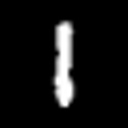
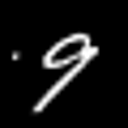
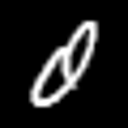
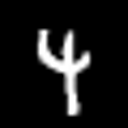
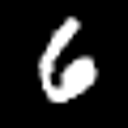
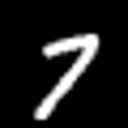
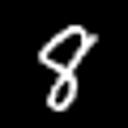
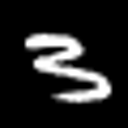
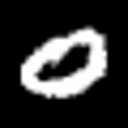
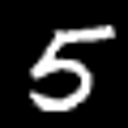
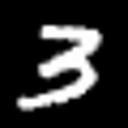
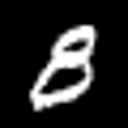
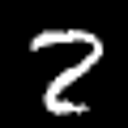
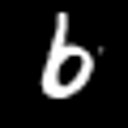
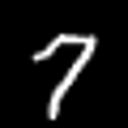
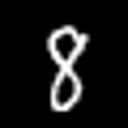

In [75]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [76]:
HP_SIGNAL_VEC_LEN = 1000 # aka SBV
HP_SIGNAL_VEC_NON_ZERO_BITS = 8
HP_SIGNAL_VEC_FEATURES_COUNT = 20
HP_SIGNAL_ENCODING = f'{HP_SIGNAL_VEC_LEN}/{HP_SIGNAL_VEC_NON_ZERO_BITS}'

HP_PIXEL_FEATURES_RANDOM_SEED = 42
HP_PIXEL_FEATURES_COUNT = 2_000

HP_POINTS_COUNT = 250_000
# HP_POINTS_COUNT = 100_000
HP_POINT_NON_ZERO_BITS = 40

## Types

In [77]:
class ClusterState(StrEnum):
    DEAD = auto()
    LEARN = auto()
    PROD_CANDIDATE = auto()
    PROD_WORK = auto()
    PROD_ETERNAL = auto()

# Constant or slow changing props. Frequently changed (hot track) props reside in sidecars
class ClusterMeta:
    def __init__(self, cluster_ind):
        self.state = ClusterState.LEARN
        self.cluster_ind = cluster_ind
        self.cluster_key = ()
        self.output_bit = 999_999_999
        self.input_bits = ()
        self.ones_count = -1
        
        # props for PROD_CANDIDATE/PROD_WORK states
        self.accuracy_calc = None
        self.verify_signal_ids = []

## Memory

In [78]:
def hdv_array_log_like_grow_policy(size):
    k = math.log(size, 100_000)
    new_size = size * 2 if k < 1 else size * 1.1
    return int(new_size)

def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

## Lambdas, Minifuncs, etc.

In [149]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cluster_key = lambda output_bit, input_bits: (int(output_bit), tuple(map(int, sorted(input_bits))))

bundle_sbvs = lambda sbvs: np.where(sbvs.sum(axis=0), 1, 0).astype('f') # aka bloom filter
debundle_sbv = lambda sbv, sbv_dict_array, non_zero_bits: (sbv_dict_array @ sbv) == non_zero_bits

# NZV = non-zero bits, e.g. [2, 3, 8]
# SBV = sparsed binary vector, e.g. [0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
def nzb_to_sbv(nzb, sbv_len):
    vec = np.zeros(sbv_len, dtype='f')
    vec[nzb] = 1
    return vec

sbv_to_nzb = lambda sbv: list(map(int, np.flatnonzero(sbv)))

# OHE = one-hot encoding
def xy_list_to_ohe_vec(xy_list):
    valid_boolmap = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[valid_boolmap]
    inds = xy_list @ np.array([1, config.sample_size])
    vec = np.zeros(config.sample_size ** 2, dtype='f')
    vec[inds] = 1
    return vec

def interval_governeur(interval, fun):
    assert interval >= 0
    countdown = interval
    
    def call(is_forced=False):
        nonlocal countdown

        if countdown <= 0 or is_forced:
            fun()
            countdown = interval
        
        countdown -= 1

    return call

def ensure_dtype(a, dt):
    assert a.dtype == dt, (a.dtype, dt)
    return a

## Average Filters

In [80]:
# https://youtu.be/HCd-leV8OkU?t=1240
class AverageFilter:
    def __init__(self):
        self.value = 0 # aka prev_average
        self.n = 0

    def __call__(self, x):
        self.n += 1
        alpha = (self.n - 1) / self.n
        result = alpha * self.value + (1 - alpha) * x
        self.value = result
        return result

In [81]:
a = 1 + np.arange(9)
f = AverageFilter()
avg = f(a[0])
assert np.isclose(avg, 1)
assert np.isclose(avg, f.value)

for x in a[1:]:
    avg = f(x)
    assert np.isclose(avg, f.value)

assert np.isclose(avg, 5)
assert np.isclose(avg, f.value)

In [82]:
# https://www.youtube.com/watch?v=HCd-leV8OkU&t=583s
# https://read.nxtbook.com/ieee/signal_processing/signal_processing_nov_2023/implementing_moving_average_f.html
class MovingAverageFilter:
    def __init__(self, n):
        assert n >= 1
        self.n = n
        self.prev_average = 0
        self.value = 0 
        self.x_queue = deque()

    def __call__(self, x):
        self.x_queue.append(x)

        while len(self.x_queue) > (self.n + 1):
            self.x_queue.popleft()

        x_old = self.x_queue[0] if len(self.x_queue) > self.n else 0
        result = self.prev_average + (x - x_old) / self.n
        self.prev_average = result

        if len(self.x_queue) < (self.n + 1):
            result = result * self.n / len(self.x_queue)

        self.value = result
        return result

In [83]:
a = np.array([55, 60, 19, 80, 30, 19, 57, 26, 36, 78, 70, 34,  5, 65, 22, 10, 53,
       28, 98,  1, 67, 94, 29, 37, 87, 98, 39, 71, 98, 68, 47, 20, 15, 13,
        3, 83, 43, 86, 95, 21,  3, 64, 20, 97, 47, 15, 78, 20, 80, 75, 31,
       11, 24, 54, 53, 42, 44,  8,  1, 74, 47, 63,  5, 34, 89, 72, 95, 17,
       69, 67, 57, 42,  2, 81, 67, 41, 14, 25, 74, 59, 78,  1, 75, 15,  7,
       70, 68, 36, 60, 46, 81,  2, 34, 39, 71, 42, 30, 48, 26, 86])
f = MovingAverageFilter(10)
avg = f(a[0])
assert np.isclose(avg, a[0])
assert np.isclose(avg, f.value)

for x in a[1:]:
    avg = f(x)
    assert np.isclose(avg, f.value)

assert np.isclose(avg, 45.9)
assert np.isclose(avg, f.value)

## Pixel Features

In [84]:
rng_for_pixel_features = np.random.default_rng(HP_PIXEL_FEATURES_RANDOM_SEED)

In [85]:
class PixelFeature:
    def __init__(self, x, y, radius, bitmap_mask, dist_mask):
        self.x = x
        self.y = y
        self.radius = radius
        self.bitmap_mask = bitmap_mask
        self.dist_mask = dist_mask
        self.sbv = None

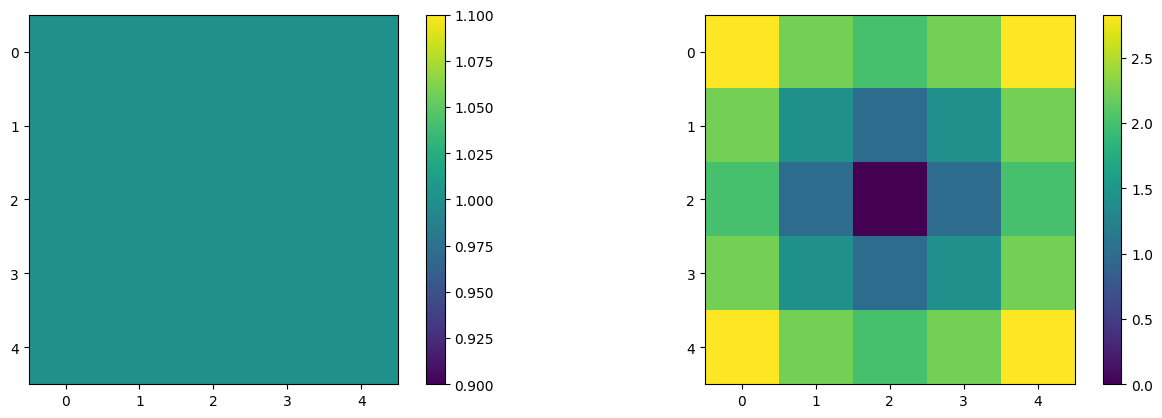

In [86]:
radius_to_pattern = {}
radius_to_dist_pattern = {} # config.sample_size if pixel if out of pattern, otherwise distance to center (within center distance = 0)

# for r in [3, 1]:
# for r in [5]:
# for r in [3]:
for r in [2]:
# for r in [1]:
    if r in [1, 2]:
        canvas = Image.new('1', size=(r * 2 + 1, r * 2 + 1), color='white')
    else:
        canvas = Image.new('1', size=(r * 2 + 1, r * 2 + 1), color='black')
        draw = ImageDraw.Draw(canvas)
        draw.circle([r, r], radius=r, outline='white', fill='white')

    pattern = np.array(canvas, dtype='f')
    radius_to_pattern[r] = pattern

    dist_pattern = np.zeros_like(pattern, dtype='f')
    
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            dist = config.sample_size
            
            if pattern[i,j] != 0:
                vec = np.array([i - r, j - r])
                dist = np.linalg.norm(vec)
                assert dist < config.sample_size

            dist_pattern[i,j] = dist
    
    radius_to_dist_pattern[r] = dist_pattern

r = max(radius_to_pattern.keys())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
im = ax1.imshow(radius_to_pattern[r])
fig.colorbar(im, ax=ax1);
im = ax2.imshow(np.where(radius_to_dist_pattern[r] < config.sample_size, radius_to_dist_pattern[r], np.inf))
fig.colorbar(im, ax=ax2);

In [87]:
# n = 50_000
# xs = rng_for_pixel_features.integers(0, config.sample_size, size=n)
# ys = rng_for_pixel_features.integers(0, config.sample_size, size=n)
# radii = rng_for_pixel_features.choice(list(radius_to_pattern.keys()), size=n)
# xy_list = np.vstack([xs, ys]).T
# assert np.all(np.all((xy_list >= 0) & (xy_list < config.sample_size), axis=1))
# bitmap_padding = 0
# bitmap = np.zeros((config.sample_size + bitmap_padding * 2, config.sample_size + bitmap_padding * 2))
# pixel_features = []

# for xy, radius in zip(xy_list, radii):
#     pattern = radius_to_pattern[radius]
#     i0, j0 = bitmap_padding, bitmap_padding
#     i = i0 + xy[1]
#     j = j0 + xy[0]
#     i_lo = i - radius
#     i_hi = i + radius + 1
#     j_lo = j - radius
#     j_hi = j + radius + 1
    
#     if i_lo < 0 or j_lo < 0 or i_hi > config.sample_size or j_hi > config.sample_size:
#         continue
    
#     merge_site = bitmap[i_lo:i_hi,j_lo:j_hi]
#     merge_site_mask = np.where(merge_site != 0, 1, 0)
#     assert pattern.shape == merge_site.shape
#     overlap_ratio = np.where(pattern != 0, merge_site_mask, 0).sum() / pattern.sum()

#     # if overlap_ratio > 0.75:
#     # if overlap_ratio > 0.5:
#     # if overlap_ratio > 0.35:
#     if overlap_ratio > 0.25:
#     # if overlap_ratio > 0.0:
#         continue
    
#     # merge_site = np.where(pattern != 0, radius, merge_site)
#     merge_site = merge_site + pattern
#     bitmap[i-radius:i+radius+1,j-radius:j+radius+1] = merge_site
#     pixel_feature_bitmap_mask = np.zeros_like(bitmap, dtype='f')
#     pixel_feature_bitmap_mask[i_lo:i_hi,j_lo:j_hi] = pattern
#     pixel_feature_bitmap_mask = pixel_feature_bitmap_mask[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]
#     pixel_feature_dist_mask = np.full_like(bitmap, config.sample_size, dtype='f')
#     pixel_feature_dist_mask[i_lo:i_hi,j_lo:j_hi] = radius_to_dist_pattern[radius]
#     pixel_feature = PixelFeature(x=int(xy[0]), y=int(xy[1]), radius=radius, bitmap_mask=pixel_feature_bitmap_mask.ravel(), dist_mask=pixel_feature_dist_mask.ravel())
#     pixel_features.append(pixel_feature)

#     if len(pixel_features) >= HP_PIXEL_FEATURES_COUNT:
#         break
    
# bitmap = bitmap[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(18)

# ax1.set_title(f'Pixel-Features Count={len(pixel_features)}, non-covered area={(bitmap == 0).sum() / (bitmap.shape[0] ** 2) * 100:.1f}%')
# im = ax1.imshow(bitmap, cmap='turbo')
# fig.colorbar(im, ax=ax1);

# random_pixel_feature_ind = rng_for_pixel_features.choice(len(pixel_features))
# ax2.set_title(f'Bitmap Mask of Pixel-Feature #{random_pixel_feature_ind}')
# im = ax2.imshow(vec_to_square_matrix(pixel_features[random_pixel_feature_ind].bitmap_mask), cmap='bwr')

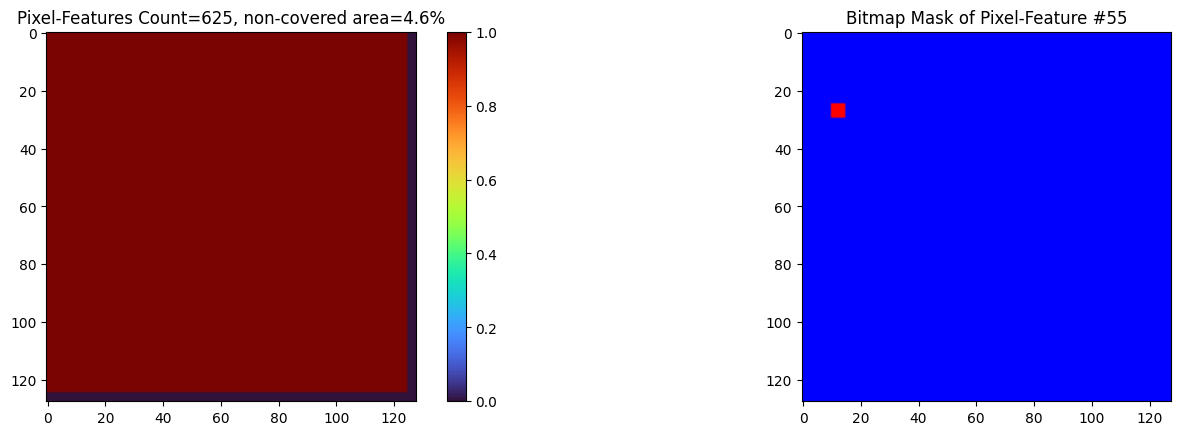

In [88]:
radius = max(radius_to_pattern.keys())

mgrid = np.mgrid[0:config.sample_size, 0:config.sample_size]
xs = mgrid[0].ravel()
ys = mgrid[1].ravel()
xy_list = np.vstack([xs, ys]).T
assert np.all(np.all((xy_list >= 0) & (xy_list < config.sample_size), axis=1))

bitmap_padding = 0
bitmap = np.zeros((config.sample_size + bitmap_padding * 2, config.sample_size + bitmap_padding * 2))
pixel_features = []

# for overlap in [0, 0.25, 0.5]:
for overlap in [0]:
    for xy in xy_list:
        if len(pixel_features) >= HP_PIXEL_FEATURES_COUNT:
            break
            
        if bitmap[xy[1], xy[0]] != 0:
            continue

        pattern = radius_to_pattern[radius]
        i0, j0 = bitmap_padding, bitmap_padding
        i = i0 + xy[1]
        j = j0 + xy[0]
        i_lo = i - radius
        i_hi = i + radius + 1
        j_lo = j - radius
        j_hi = j + radius + 1
        
        if i_lo < 0 or j_lo < 0 or i_hi > config.sample_size or j_hi > config.sample_size:
            continue
        
        merge_site = bitmap[i_lo:i_hi,j_lo:j_hi]
        merge_site_mask = np.where(merge_site != 0, 1, 0)
        assert pattern.shape == merge_site.shape
        overlap_ratio = np.where(pattern != 0, merge_site_mask, 0).sum() / pattern.sum()
    
        if overlap_ratio > overlap:
            continue
        
        merge_site = merge_site + pattern
        bitmap[i-radius:i+radius+1,j-radius:j+radius+1] = merge_site
        pixel_feature_bitmap_mask = np.zeros_like(bitmap, dtype='f')
        pixel_feature_bitmap_mask[i_lo:i_hi,j_lo:j_hi] = pattern
        pixel_feature_bitmap_mask = pixel_feature_bitmap_mask[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]
        pixel_feature_dist_mask = np.full_like(bitmap, config.sample_size, dtype='f')
        pixel_feature_dist_mask[i_lo:i_hi,j_lo:j_hi] = radius_to_dist_pattern[radius]
        pixel_feature = PixelFeature(x=int(xy[0]), y=int(xy[1]), radius=radius, bitmap_mask=pixel_feature_bitmap_mask.ravel(), dist_mask=pixel_feature_dist_mask.ravel())
        pixel_features.append(pixel_feature)
    
bitmap = bitmap[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title(f'Pixel-Features Count={len(pixel_features)}, non-covered area={(bitmap == 0).sum() / (bitmap.shape[0] ** 2) * 100:.1f}%')
im = ax1.imshow(bitmap, cmap='turbo')
fig.colorbar(im, ax=ax1);

random_pixel_feature_ind = rng_for_pixel_features.choice(len(pixel_features))
ax2.set_title(f'Bitmap Mask of Pixel-Feature #{random_pixel_feature_ind}')
im = ax2.imshow(vec_to_square_matrix(pixel_features[random_pixel_feature_ind].bitmap_mask), cmap='bwr')

In [89]:
df_pixel_features = pd.read_sql('SELECT x, y, radius, nzb FROM features WHERE encoding=:encoding AND type=:type', 
                                params={'encoding': HP_SIGNAL_ENCODING, 'type': 'pixel'}, con=transfs_db_con)
db_pixel_features_dict = dict(map(lambda p: ((p.x, p.y, p.radius), nzb_to_sbv(pickle.loads(p.nzb), HP_SIGNAL_VEC_LEN)), df_pixel_features.itertuples()))
unique_sbv_keys = set(map(lambda sbv: tuple(sorted(map(int, np.flatnonzero(sbv)))), db_pixel_features_dict.values()))
assert len(unique_sbv_keys) == len(db_pixel_features_dict)
print(f'Loaded {len(unique_sbv_keys)} pixel features')
new_pixel_features = []
linked_count = 0

for pf in pixel_features:
    key = (pf.x, pf.y, pf.radius)

    if key in db_pixel_features_dict:
        pf.sbv = db_pixel_features_dict[key]
        linked_count += 1
        continue
        
    attempts_to_generate_unique_sbv = 10
    sbv = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')

    for _ in range(attempts_to_generate_unique_sbv):
        ii = RNG.choice(HP_SIGNAL_VEC_LEN, HP_SIGNAL_VEC_NON_ZERO_BITS, replace=False)
        sbv_key = tuple(sorted(ii))

        if not sbv_key in unique_sbv_keys:
            sbv[ii] = 1
            unique_sbv_keys.add(sbv_key)
            break
    else:
        assert False, f'Failed to get unique SBV for pixel feature within {attempts_to_generate_unique_sbv} attempts'

    new_pixel_features.append(pf)
    pf.sbv = sbv

print(f'Linked {linked_count} pixel features')

if new_pixel_features:
    transfs_db_con.autocommit = False
    
    for pf in tqdm(new_pixel_features, desc='Persiting'):
        transfs_db_con.execute('INSERT INTO features(encoding, type, x, y, radius, bitmap_mask_nzb, nzb) VALUES (:encoding, :type, :x, :y, :radius, :bitmap_mask_nzb, :nzb)',
                               {
                                   'encoding': HP_SIGNAL_ENCODING, 
                                   'type': 'pixel', 
                                   'x': pf.x, 
                                   'y': pf.y, 
                                   'radius': pf.radius, 
                                   'bitmap_mask_nzb': pickle.dumps(sbv_to_nzb(pf.bitmap_mask)),
                                   'nzb': pickle.dumps(sbv_to_nzb(pf.sbv))
                               })

    transfs_db_con.autocommit = True
    print(f'Created and persisted {len(new_pixel_features)} new pixel features')

PIXEL_FEATURE_SBVS = np.array(list(map(lambda pf: pf.sbv, pixel_features)))
PIXEL_FEATURE_BITMAP_MASKS = np.array(list(map(lambda pf: pf.bitmap_mask, pixel_features)))
PIXEL_FEATURE_DIST_MASKS = np.array(list(map(lambda pf: pf.dist_mask, pixel_features)))
PIXEL_FEATURE_XY_ARRAY = np.array(list(map(lambda pf: (pf.x, pf.y), pixel_features)))

Loaded 3117 pixel features
Linked 625 pixel features


In [90]:
df_train_images_ = df_train_images.head(2000)
# df_train_images_ = df_train_images
gpu_pixel_feature_bitmap_masks = xp_array_to_gpu(PIXEL_FEATURE_BITMAP_MASKS)
PIXEL_FEATURE_FREQS = np.zeros(PIXEL_FEATURE_SBVS.shape[0], dtype='i')

for image in tqdm(df_train_images_.itertuples(), total=len(df_train_images_)):
    sequences = pickle.loads(image.inner_sequences)
    si_ind_dict = pickle.loads(image.inner_si_ind_dict)
    xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
    ohe_vec = xy_list_to_ohe_vec(xy_list_full)
    ohe_vec = xp_array_to_gpu(ohe_vec)
    pixel_feature_inds = np.flatnonzero(gpu_pixel_feature_bitmap_masks @ ohe_vec)
    pixel_feature_inds = xp_array_from_gpu(pixel_feature_inds)
    PIXEL_FEATURE_FREQS[pixel_feature_inds] += 1

ACTIVE_PIXEL_FEATURES_COUNT = np.count_nonzero(PIXEL_FEATURE_FREQS)

  0%|          | 0/2000 [00:00<?, ?it/s]

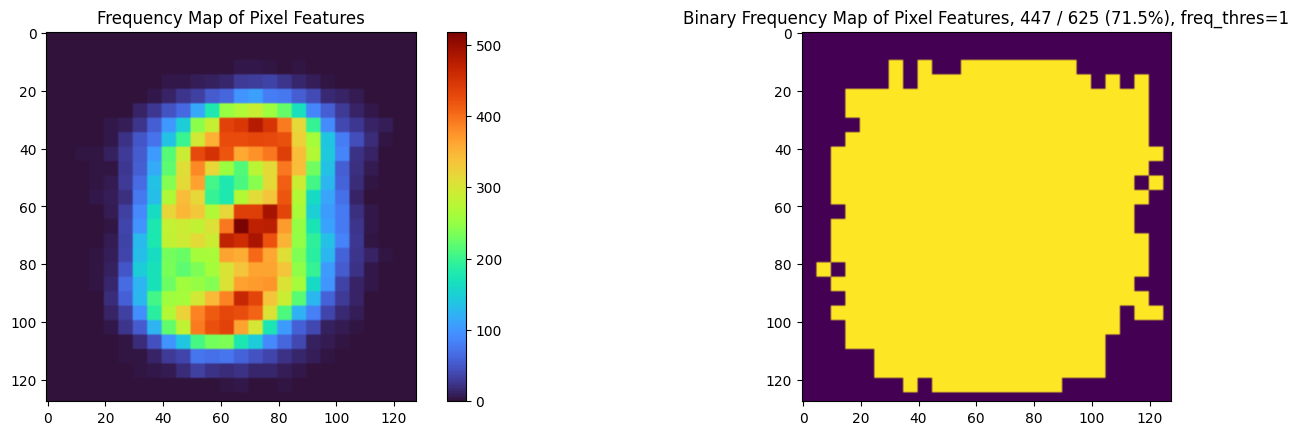

In [91]:
bitmap = np.zeros((config.sample_size, config.sample_size), dtype='i')
assert PIXEL_FEATURE_BITMAP_MASKS.shape[0] == PIXEL_FEATURE_FREQS.shape[0]

for mask, freq in zip(xp_array_from_gpu(PIXEL_FEATURE_BITMAP_MASKS), PIXEL_FEATURE_FREQS):
    mask_with_freq = np.where(mask, freq, 0)
    bitmap += mask_with_freq.reshape(bitmap.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title(f'Frequency Map of Pixel Features')
im = ax1.imshow(bitmap, cmap='turbo')
fig.colorbar(im, ax=ax1)

pixel_feature_freqs_sorted_desc = -np.sort(-PIXEL_FEATURE_FREQS)
percentile = 1
ind = int(np.count_nonzero(pixel_feature_freqs_sorted_desc) * percentile)
freq_thres = pixel_feature_freqs_sorted_desc[ind-1]
# bitmap2 = np.where(bitmap, 1, 0)
bitmap2 = np.where(PIXEL_FEATURE_BITMAP_MASKS[(PIXEL_FEATURE_FREQS >= freq_thres)].sum(axis=0), 1, 0)
# bitmap2 = xp_array_from_gpu(bitmap2)
bitmap2 = vec_to_square_matrix(bitmap2)
# a = (PIXEL_FEATURE_FREQS > 0).sum()
a = (PIXEL_FEATURE_FREQS >= freq_thres).sum()
b = PIXEL_FEATURE_BITMAP_MASKS.shape[0]
ax2.set_title(f'Binary Frequency Map of Pixel Features, {a} / {b} ({a / b * 100:.1f}%), freq_thres={freq_thres}')
ax2.imshow(bitmap2);

## Transformations

In [92]:
def get_rotate_transf(deg):
    half_sz = config.sample_size / 2
    move_to_ooc_transf = np.array([
        [1, 0, -half_sz],
        [0, 1, -half_sz],
        [0, 0, 1]])
    theta = np.deg2rad(deg)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    rotate_transf = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    move_to_target_loc_transf = np.array([
        [1, 0, half_sz],
        [0, 1, half_sz],
        [0, 0, 1]])
    return move_to_target_loc_transf @ rotate_transf @ move_to_ooc_transf

def get_offset_transf(dx=0, dy=0):
    return np.array([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0, 1]])

In [93]:
transfs = {
    'offset_10_0': get_offset_transf(10, 0),
    'offset_1_0': get_offset_transf(1, 0),
    'offset_-1_0': get_offset_transf(-1, 0),
    'offset_0_1': get_offset_transf(0, 1),
    'offset_1_1': get_offset_transf(1, 1),
    'offset_5_0': get_offset_transf(5, 0),
    'rotate_45': get_rotate_transf(45),
    'rotate_90': get_rotate_transf(90),
}
TRANSF_CODE = 'rotate_45'
TRANSF = transfs[TRANSF_CODE]

## XY List <-> Pixel Features

In [94]:
def xy_list_to_pixel_feature_inds(xy_list):
    ohe_vec = xy_list_to_ohe_vec(xy_list)
    # ohe_vec = xp_array_to_gpu(ohe_vec)
    inds = np.flatnonzero(PIXEL_FEATURE_BITMAP_MASKS @ ohe_vec)
    # return xp_array_from_gpu(inds)
    return inds

def xy_list_to_nearest_pixel_feature_inds(xy_list):
    valid_boolmap = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[valid_boolmap]
    inds = xy_list @ np.array([1, config.sample_size])
    vecs = np.zeros((inds.shape[0], config.sample_size ** 2), dtype='f')

    for i, j in enumerate(inds):
        vecs[i,j] = 1

    # compute matrix where rows correspond to xy pairs and columns correspond to pixel features
    # value in cell [i,j] == dist_from_xy[i]_to_center_of_pixel_feature[j]
    mat = vecs @ PIXEL_FEATURE_DIST_MASKS.T
    # for each xy get index of pixel feature which has minimal distance to center of pixel feature
    t = np.argmin(mat, axis=1)
    # if row consists of dists which exceed config.sample_size then np.argmin has no sense for such row (it means that there is no match with any pixel feature),
    # as such - exclude such row from consideration
    rows_with_good_values_boolmap = np.any(mat < config.sample_size, axis=1)
    t = t[rows_with_good_values_boolmap]
    return np.unique(t)

## Signals Generator

In [95]:
SignalsGeneratorResult = namedtuple('SignalsGeneratorResult', 
                                    ['signals_input', 'signals_output', # SBV
                                     'signal_ids', 
                                     'signal_xy_lists_input', 'signal_xy_lists_output', 
                                     'xy_list_full'])
DummySignalsGeneratorResult = lambda: SignalsGeneratorResult([], [], [], [], [], [])

### RealImageSignalsGenerator

In [96]:
# For each image generate number of signals (image_variants_count) by randomly select of si_ind and convert this si_ind to pixel features
class RealImageSignalsGenerator:
    def __init__(self, transf, signals_count, image_variants_count, logger=lambda m: True):
        self.transf = transf
        self.signals_count = signals_count
        assert image_variants_count > 0
        self.image_variants_count = image_variants_count

        self.image_id = -1
        self.image_variants_count_for_image_id = 0
        self.image_variants_generated = 0
        self.xy_list_full = []
        self.xy_list_inds_count = -1
        
    def __call__(self):
        signals_input = []
        signals_output = []
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.image_id == -1 or self.image_variants_generated >= self.image_variants_count_for_image_id:
                # the very first call or variants of current image are exhausted, switch to next image
                self.image_id = int(RNG.choice(df_train_images.index))
                self.image_variants_generated = 0
                image = df_train_images.loc[self.image_id]
                # pickle.loads consumes almost 50% of the time of execution of generate() :=(
                sequences = pickle.loads(image.inner_sequences)
                si_ind_dict = pickle.loads(image.inner_si_ind_dict)
                xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
                self.xy_list_full = xy_list_full
                
                xy_list_inds_count = min(xy_list_full.shape[0], HP_SIGNAL_VEC_FEATURES_COUNT)
                xy_list_combinations_count = math.comb(xy_list_full.shape[0], xy_list_inds_count)

                if xy_list_combinations_count >= self.image_variants_count:
                    self.xy_list_inds_count = xy_list_inds_count
                    self.image_variants_count_for_image_id = self.image_variants_count
                else:
                    assert xy_list_inds_count > 0
                    xy_list_inds_count_to_combinations_count = Counter()
                
                    for inds_count in range(xy_list_inds_count, 0, -1):
                        xy_list_inds_count_to_combinations_count[inds_count] = math.comb(xy_list_full.shape[0], inds_count)

                    xy_list_inds_count_with_most_variants = xy_list_inds_count_to_combinations_count.most_common(1)[0]
                    self.xy_list_inds_count = xy_list_inds_count_with_most_variants[0]
                    self.image_variants_count_for_image_id = min(self.image_variants_count, xy_list_inds_count_with_most_variants[1])
            
                self.xy_list_inds_count > 0
                self.xy_list_inds_count <= self.xy_list_full.shape[0]
                assert self.image_variants_count_for_image_id > 0, self.image_variants_count_for_image_id
                assert self.image_variants_count_for_image_id <= self.image_variants_count, self.image_variants_count_for_image_id

            xy_list_inds = RNG.choice(self.xy_list_full.shape[0], self.xy_list_inds_count, replace=False)
            xy_list_origin = self.xy_list_full[xy_list_inds]
            ###
            xy_list_origin = PIXEL_FEATURE_XY_ARRAY[xy_list_to_pixel_feature_inds(xy_list_origin)]
            ###
            xy_list_transf = np.hstack([xy_list_origin, np.ones(xy_list_origin.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            xy_list_origin_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[xy_list_to_pixel_feature_inds(xy_list_origin)])
            xy_list_transf_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[xy_list_to_pixel_feature_inds(xy_list_transf)])
            assert xy_list_origin_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_transf_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            
            self.image_variants_generated += 1
            signals_input.append(xy_list_origin_sbv)
            signals_output.append(xy_list_transf_sbv)
            signal_ids.append((self.image_id, tuple(map(int, sorted(xy_list_inds)))))
            signal_xy_lists_input.append(xy_list_origin)
            signal_xy_lists_output.append(xy_list_transf)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output), 
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=self.xy_list_full)

    def switch(self):
        pass

In [97]:
generator = RealImageSignalsGenerator(TRANSF, 100, 10)

In [98]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 7.97 s, sys: 5.08 ms, total: 7.98 s
Wall time: 129 ms


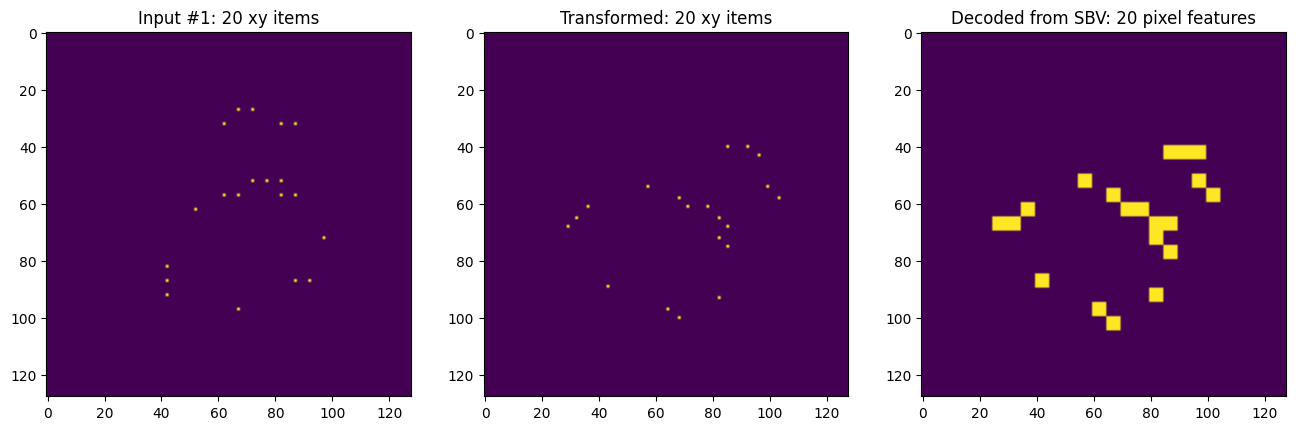

In [99]:
# signal_ind = RNG.choice(len(sgr.signals_output))
# signal_ind = 19
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### FixedPixelFeatureSignalsGenerator

In [100]:
# one pixel feature is fixed for a number calls (fixation period) and remaining features are randomly picked according to their frequency
class FixedPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, fixation_period, logger=lambda m: True):
        self.transf = transf
        self.signals_count = signals_count
        assert fixation_period > 0
        self.fixation_period = fixation_period
        self.fixation_countdown = self.fixation_period
        self.fixed_pixel_feature_ind = -1
        self.pixel_feature_inds_sorted_by_freq_desc = np.argsort(-PIXEL_FEATURE_FREQS)
        # strip pixel features which have zero freqs, i.o.w. leave only those with nonzero
        active_pixel_features_count = np.count_nonzero(PIXEL_FEATURE_FREQS)
        assert active_pixel_features_count > 0
        self.pixel_feature_inds_sorted_by_freq_desc = self.pixel_feature_inds_sorted_by_freq_desc[:active_pixel_features_count]
        assert self.pixel_feature_inds_sorted_by_freq_desc.shape[0] == active_pixel_features_count
        self.pixel_feature_inds = np.arange(PIXEL_FEATURE_SBVS.shape[0])
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.fixed_pixel_feature_ind == -1 or self.fixation_countdown <= 0:
                self.fixed_pixel_feature_ind = self.pixel_feature_inds_sorted_by_freq_desc[0]
                self.pixel_feature_inds_sorted_by_freq_desc = np.roll(self.pixel_feature_inds_sorted_by_freq_desc, -1)
                # temporarily ban fixed pixel feature from being picked up as a free one
                self.free_pixel_feature_probs = PIXEL_FEATURE_FREQS[:].astype('f')
                self.free_pixel_feature_probs[self.fixed_pixel_feature_ind] = 0
                self.free_pixel_feature_probs /= self.free_pixel_feature_probs.sum()
                self.fixation_countdown = self.fixation_period

            assert self.fixed_pixel_feature_ind != -1
            # pick up remaining pixel feature (via their probabilities) excluding fixed pixel feature
            free_pixel_feature_inds = RNG.choice(self.pixel_feature_inds, HP_SIGNAL_VEC_FEATURES_COUNT-1, p=self.free_pixel_feature_probs, replace=False)
            pixel_feature_inds_input = np.hstack([self.fixed_pixel_feature_ind, free_pixel_feature_inds])
            assert pixel_feature_inds_input.shape[0] == HP_SIGNAL_VEC_FEATURES_COUNT

            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap among pixel features
            # pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            self.fixation_countdown -= 1
            
            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output),
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

    def switch(self):
        pass

In [101]:
generator = FixedPixelFeatureSignalsGenerator(TRANSF, 100, 10)

In [102]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 4.61 s, sys: 2.98 ms, total: 4.62 s
Wall time: 73.8 ms


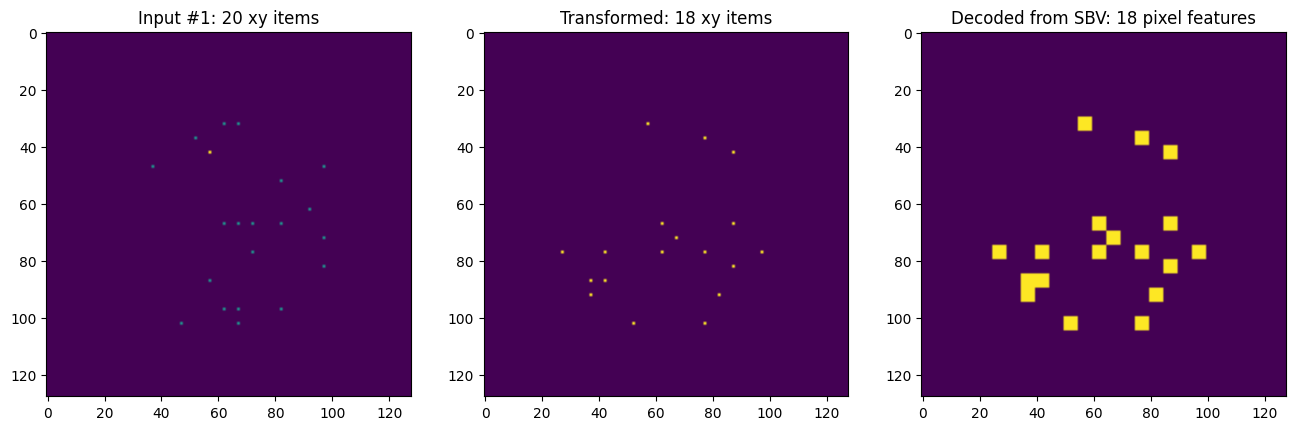

In [103]:
# signal_ind = RNG.choice(len(sgr.signals_output))
# signal_ind = 19
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
t = xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])
t[PIXEL_FEATURE_XY_ARRAY[generator.fixed_pixel_feature_ind] @ [1, config.sample_size]] = 2
ax1.imshow(vec_to_square_matrix(t))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### RollingPixelFeatureSignalsGenerator

In [104]:
# On every call specified number (fresh_count) of pixel features is replaced with a fresh ones
class RollingPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, fresh_count, logger=lambda m: True):
        self.transf = transf
        self.signals_count = signals_count
        assert fresh_count > 0
        self.fresh_count = fresh_count
        self.pixel_feature_inds_fifo = np.array([])
        self.pixel_feature_inds_set = set()
        self.pixel_feature_probs = PIXEL_FEATURE_FREQS[:].astype('f')
        self.pixel_feature_probs /= self.pixel_feature_probs.sum()
        self.pixel_features_count = PIXEL_FEATURE_FREQS.shape[0]
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.pixel_feature_inds_fifo.shape[0] == 0:
                self.pixel_feature_inds_fifo = RNG.choice(self.pixel_features_count, HP_SIGNAL_VEC_FEATURES_COUNT, p=self.pixel_feature_probs, replace=False)
                self.pixel_feature_inds_set = set(self.pixel_feature_inds_fifo)
            else:
                fresh_pixel_features_gathered = 0
                
                for _ in range(self.fresh_count):
                    for _ in range(self.pixel_features_count):
                        new_pixel_feature_ind = RNG.choice(self.pixel_features_count, p=self.pixel_feature_probs)

                        if not new_pixel_feature_ind in self.pixel_feature_inds_set:
                            self.pixel_feature_inds_fifo = np.hstack([self.pixel_feature_inds_fifo, new_pixel_feature_ind])
                            self.pixel_feature_inds_set.add(new_pixel_feature_ind)
                            fresh_pixel_features_gathered += 1
                            break
                    else:
                        # failed to find new pixel feature ind which is not within self.pixel_feature_inds_fifo, =(
                        # maybe next call will be more successful...
                        pass

                assert fresh_pixel_features_gathered >=0 and fresh_pixel_features_gathered <= self.fresh_count, fresh_pixel_features_gathered
                removed_pixel_feature_inds = self.pixel_feature_inds_fifo[:fresh_pixel_features_gathered]
                self.pixel_feature_inds_fifo = self.pixel_feature_inds_fifo[fresh_pixel_features_gathered:]
                for ind in removed_pixel_feature_inds: self.pixel_feature_inds_set.remove(ind)

            pixel_feature_inds_input = self.pixel_feature_inds_fifo
            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap among pixel features
            # pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            
            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output),
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

    def switch(self):
        pass

In [105]:
generator = RollingPixelFeatureSignalsGenerator(TRANSF, 100, 1)

In [106]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 3.76 s, sys: 2.61 ms, total: 3.76 s
Wall time: 60.3 ms


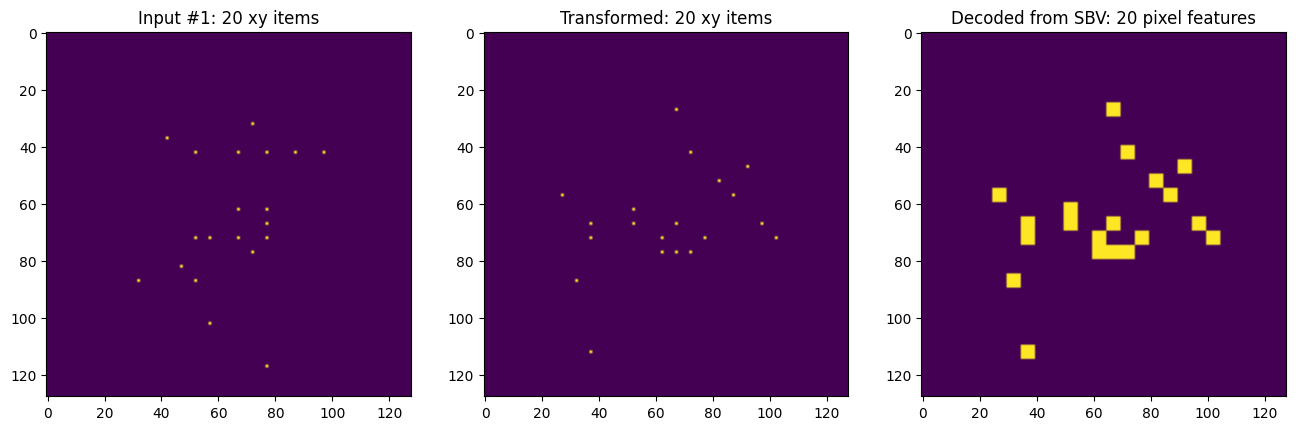

In [107]:
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### PooledPixelFeatureSignalsGenerator

In [160]:
# Create pool of pixel features of designated size (pool_size) and sample signals from that pool. 
# Recreate pool on switch call
class PooledPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, pool_size, logger=lambda m: True):
        self.logger = logger
        self.transf = transf
        self.signals_count = signals_count
        assert pool_size >= HP_SIGNAL_VEC_FEATURES_COUNT
        self.pool_size = pool_size
        self.pooled_pixel_feature_inds = np.array([])
        self.pixel_feature_inds_sorted_by_freq_desc = np.argsort(-PIXEL_FEATURE_FREQS)
        # strip pixel features which have zero freqs, i.o.w. leave only those with nonzero
        active_pixel_features_count = np.count_nonzero(PIXEL_FEATURE_FREQS)
        assert active_pixel_features_count > 0
        self.pixel_feature_inds_sorted_by_freq_desc = self.pixel_feature_inds_sorted_by_freq_desc[:active_pixel_features_count]
        assert self.pixel_feature_inds_sorted_by_freq_desc.shape[0] == active_pixel_features_count
        self.switch()
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            pixel_feature_inds_input = RNG.choice(self.pooled_pixel_feature_inds, HP_SIGNAL_VEC_FEATURES_COUNT, replace=False)
            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap among pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN

            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output),
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

    def switch(self):
        self.pooled_pixel_feature_inds = self.pixel_feature_inds_sorted_by_freq_desc[:self.pool_size]
        self.pixel_feature_inds_sorted_by_freq_desc = np.roll(self.pixel_feature_inds_sorted_by_freq_desc, -self.pool_size)
        l = self.pooled_pixel_feature_inds[0]
        h = self.pooled_pixel_feature_inds[-1]
        self.logger(f'Pool inds=[{l}, ..., {h}], freqs=[{PIXEL_FEATURE_FREQS[l]}, ..., {PIXEL_FEATURE_FREQS[h]}]')
        assert self.pooled_pixel_feature_inds.shape[0] >= HP_SIGNAL_VEC_FEATURES_COUNT

In [109]:
generator = PooledPixelFeatureSignalsGenerator(TRANSF, 100, 30, logger=lambda m: print(m))

Pool inds=[338, ..., 308], freqs=[518, ..., 418]


In [110]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 3.26 s, sys: 2.28 ms, total: 3.27 s
Wall time: 52.6 ms


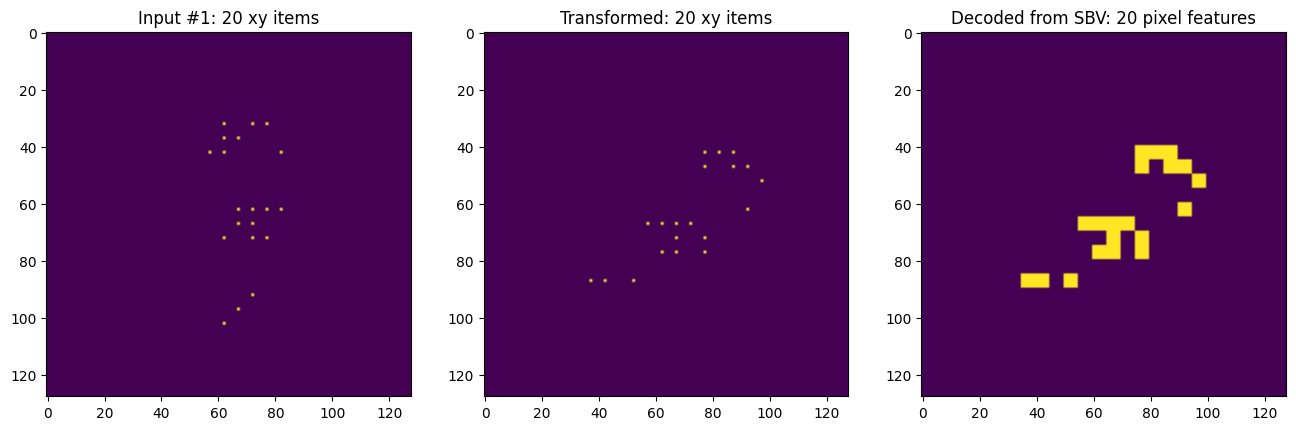

In [111]:
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### AsyncSignalsGenerator

In [112]:
@dataclass
class AsyncSignalsGeneratorTask:
    task_id: int
    op: str
    params: dict = None

@dataclass
class AsyncSignalsGeneratorTaskResult:
    task_id: int
    payload: typing.Any = None

def async_signals_generator_fun(generator_typename, inp_queue, out_queue, *args):
    LOG.app_name = 'HOST_ASG'
    LOG(f'Starting host for async signals generator {generator_typename}')

    match generator_typename:
        case RealImageSignalsGenerator.__name__:
            generator = RealImageSignalsGenerator(*args, logger=LOG)
        case FixedPixelFeatureSignalsGenerator.__name__:
            generator = FixedPixelFeatureSignalsGenerator(*args, logger=LOG)
        case RollingPixelFeatureSignalsGenerator.__name__:
            generator = RollingPixelFeatureSignalsGenerator(*args, logger=LOG)
        case PooledPixelFeatureSignalsGenerator.__name__:
            generator = PooledPixelFeatureSignalsGenerator(*args, logger=LOG)
        case _:
            assert False, generator_typename

    LOG(f'Host is ready')

    task_wait_timeout = 60
    is_running = True
    is_recreate_pending = True

    while is_running:
        if is_recreate_pending:
            LOG('Begin generating signals')
            sgr = generator()
            LOG('End generating signals')
            is_recreate_pending = False
            
        try:
            task = inp_queue.get(block=True, timeout=task_wait_timeout)
        except queue.Empty:
            LOG(f'Didn\'t get any tasks within {task_wait_timeout} seconds, waiting again')
            continue

        with LOG.auto_prefix('TASK_ID', task.task_id):
            LOG(f'Got task #{task.task_id} {task.op}')
            task_result = AsyncSignalsGeneratorTaskResult(task_id=task.task_id)
            
            match task.op:
                case 'HEALTHCHECK':
                    pass
                case 'TERMINATE':
                    is_running = False
                case 'GENERATE':
                    task_result.payload = sgr
                    is_recreate_pending = True
                case 'SWITCH':
                    generator.switch()
                    is_recreate_pending = True
                case _:
                    LOG(f'Unknown task op: {task.op}, ignoring')
    
            out_queue.put(task_result)
            LOG('Task complete')
        
    LOG(f'Host is going down')
        
class AsyncSignalsGenerator:
    task_id = 0
    
    def __init__(self, generator_type, *args):
        mp_ctx = mp.get_context('fork')
        self.task_queue = mp_ctx.Queue()
        self.result_queue = mp_ctx.Queue()
        self.process = mp_ctx.Process(target=async_signals_generator_fun, 
                                      args=(generator_type.__name__, self.task_queue, self.result_queue, *args))
        self.process.start()

    @staticmethod
    def gen_task_id():
        AsyncSignalsGenerator.task_id += 1
        return AsyncSignalsGenerator.task_id

    def healthcheck(self):
        assert self.process.is_alive()
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='HEALTHCHECK')
        self.task_queue.put(task)
        self.result_queue.get(timeout=3)
        
    def terminate(self):
        if not self.process.is_alive():
            return
            
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='TERMINATE')
        self.task_queue.put(task)
        try:
            self.result_queue.get(timeout=10)
            self.process.join()
        except queue.Empty:
            print('Failed to shutdown host gracefully, terminating')
            self.process.terminate()

    def __call__(self):
        assert self.process.is_alive()
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='GENERATE')
        self.task_queue.put(task)
        sgr = self.result_queue.get().payload
        return sgr

    def switch(self):
        assert self.process.is_alive()
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='SWITCH')
        self.task_queue.put(task)
        self.result_queue.get()

In [113]:
try:
    # test_signals_generator = AsyncSignalsGenerator(RealImageSignalsGenerator, TRANSF, 100, 10)
    # test_signals_generator = AsyncSignalsGenerator(FixedPixelFeatureSignalsGenerator, TRANSF, 100, 10)
    # test_signals_generator = AsyncSignalsGenerator(RollingPixelFeatureSignalsGenerator, TRANSF, 100, 10)
    test_signals_generator = AsyncSignalsGenerator(PooledPixelFeatureSignalsGenerator, TRANSF, 100, 30)
    test_signals_generator.healthcheck()
    print(f'Async signals generator is ready')
    %time sgr = test_signals_generator()
finally:
    test_signals_generator.terminate()
    print(f'Async signals generator terminated')
    del test_signals_generator

Async signals generator is ready
CPU times: user 6.88 ms, sys: 10 ms, total: 16.9 ms
Wall time: 28.7 ms
Async signals generator terminated


## Points

In [114]:
df_points = pd.read_sql('SELECT output_bit, nzb_list FROM points WHERE encoding=:encoding AND count=:count AND non_zero_bits=:non_zero_bits', 
                        params={
                            'encoding': HP_SIGNAL_ENCODING,
                            'count': HP_POINTS_COUNT,
                            'non_zero_bits': HP_POINT_NON_ZERO_BITS}, 
                        con=transfs_db_con)

if len(df_points) > 0:
    POINTS = []
    POINT_OUTPUT_BITS = []
    
    for row in tqdm(df_points.itertuples(), total=len(df_points), desc='Load'):
        nzb_list = pickle.loads(row.nzb_list)
        l = len(nzb_list)
        assert l > 0
        points = np.zeros((l, HP_SIGNAL_VEC_LEN), dtype='f')

        for i, nzb in enumerate(nzb_list):
            points[i,nzb] = 1

        POINTS.append(points)
        
        point_output_bits = np.full(l, row.output_bit, dtype='i')
        POINT_OUTPUT_BITS.append(point_output_bits)
        
    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert np.all(POINTS.sum(axis=1) == HP_POINT_NON_ZERO_BITS)
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]
    assert POINTS.ndim == 2
    assert POINT_OUTPUT_BITS.ndim == 1
    print(f'{POINTS.shape[0]:_} POINTS loaded from database')
else:
    POINTS = []
    POINT_OUTPUT_BITS = []
    output_bits = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINTS_COUNT)
    output_bit_to_nzb_list = defaultdict(list)
    
    for output_bit in tqdm(output_bits, desc='Generate'):
        nzb = sbv_to_nzb(RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINT_NON_ZERO_BITS, replace=False))
        
        point_vec = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
        point_vec[nzb] = 1
        POINTS.append(point_vec)
        POINT_OUTPUT_BITS.append(output_bit)

        output_bit_to_nzb_list[output_bit].append(nzb)

    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert np.all(POINTS.sum(axis=1) == HP_POINT_NON_ZERO_BITS)
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]

    for output_bit, nzb_list in tqdm(output_bit_to_nzb_list.items(), desc='Save'):
        params = {
            'encoding': HP_SIGNAL_ENCODING, 
            'count': HP_POINTS_COUNT,
            'non_zero_bits': HP_POINT_NON_ZERO_BITS,
            'output_bit': int(output_bit),
            'nzb_list': pickle.dumps(nzb_list),
            }
        transfs_db_con.execute('INSERT INTO points(encoding, count, non_zero_bits, output_bit, nzb_list) ' + 
                               'VALUES(:encoding, :count, :non_zero_bits, :output_bit, :nzb_list)', params)
    
    print(f'{POINTS.shape[0]:_} POINTS created from scratch')

Load:   0%|          | 0/1000 [00:00<?, ?it/s]

250_000 POINTS loaded from database


## .lab hdc

In [115]:
# hdc = Hdc(10_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.055
# hdc.hdist_threshold = 4700

hdc = Hdc(1_000, np, dtype='f')
hdc.bundle = hdc.bundle_noties
hdc.cos_sim_threshold = 0.10

# hdc = Hdc(2_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.10

In [116]:
PIXEL_HDVS = hdc(config.sample_size ** 2)
PIXEL_HDVS_NORM = hdc.normalize(PIXEL_HDVS)

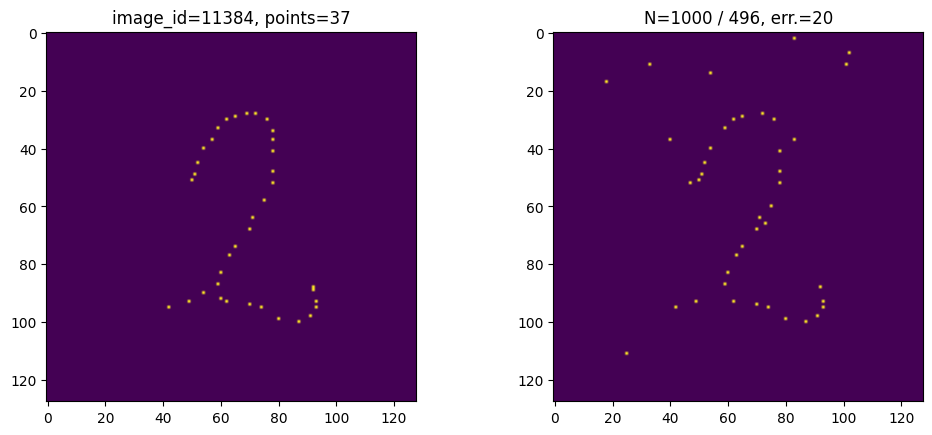

In [117]:
image_id = RNG.choice(df_train_images.index)
image = next(df_train_images.loc[[image_id]].itertuples())
si_ind_dict = pickle.loads(image.inner_si_ind_dict)
sequences = pickle.loads(image.inner_sequences)
seq = get_sequence(sequences)
seq_xy = get_xy_sequence(seq, si_ind_dict)
ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
seq_xy = seq_xy[ii]
ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv_true[ind_seq] = 1

seq_hdv = hdc.bundle(PIXEL_HDVS[ind_seq])
seq_hdv_binary = hdc.to_binary(seq_hdv)
seq_hdv_bipolar = hdc.to_bipolar(seq_hdv_binary)
seq_hdv_bipolar_norm = hdc.normalize(seq_hdv_bipolar)
pixel_hdv_inds = np.argwhere((PIXEL_HDVS_NORM @ seq_hdv_bipolar_norm) > hdc.cos_sim_threshold).ravel()
seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv[pixel_hdv_inds] = 1

error_level = np.count_nonzero(seq_bv != seq_bv_true)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
ax1.imshow(seq_bv_true.reshape(config.sample_size, -1));
ax2.set_title(f'err.={error_level}')
ax2.set_title(f'N={seq_hdv.shape[0]} / {seq_hdv_binary.sum():.0f}, err.={error_level}')
ax2.imshow(seq_bv.reshape(config.sample_size, -1));

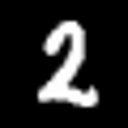

In [118]:
get_raw_image(image_id)

## .lab sbv

In [119]:
# # image_id = RNG.choice(df_train_images.index)
# # image_id = 44917 # 60 points
# image = next(df_train_images.loc[[image_id]].itertuples())
# si_ind_dict = pickle.loads(image.inner_si_ind_dict)
# sequences = pickle.loads(image.inner_sequences)
# seq = get_sequence(sequences)
# seq_xy = get_xy_sequence(seq, si_ind_dict)
# ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
# seq_xy = seq_xy[ii]
# ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
# seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
# seq_bv_true[ind_seq] = 1

# # seq_sbv = np.where(np.sum(PIXELS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
# seq_sbv = calc_seq_sbv(seq_xy)
# # pixel_sbv_inds = np.argwhere((PIXELS @ seq_sbv) >= SBV_NON_ZERO_INDS).ravel()
# # seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
# # seq_bv[pixel_sbv_inds] = 1
# seq_bv = seq_sbv_to_bv(seq_sbv)

# error_level = np.count_nonzero(seq_bv != seq_bv_true)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(12)
# ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
# ax1.imshow(seq_bv_true.reshape(config.sample_size, -1))
# ax2.set_title(f'sbv={seq_sbv.shape[0]} / {seq_sbv.sum()}, non_zero_inds={HP_SIGNAL_VEC_NON_ZERO_BITS}, err.={error_level}')
# ax2.imshow(seq_bv.reshape(config.sample_size, -1));

# Train

## Parameters

In [120]:
LOG.is_enabled = True

In [121]:
HP_CLUSTER_ONES_COUNT_THRES = 6
HP_CLUSTER_CREATION_ONES_COUNT_THRES = 7
HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE = (5, 10)
HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE = (5,)
HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE = max(len(HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE), len(HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE))
HP_CLUSTER_BINARIZE_THRES = 0.75
HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES = 10
HP_CLUSTER_PROD_WORK_ACCURACY_THRES = 0.9
HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES = 100
HP_CLUSTER_PROD_ETERNAL_ACCURACY_THRES = 0.98
        
HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT = 300_000
HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT = 100_000
HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT = 100_000

HP_EPOCHS_COUNT = 1
HP_OUTPUT_BITS_PER_BATCH = 250
HP_NEW_SIGNALS_COUNT_PER_CYCLE = min(100, len(df_train_images))
HP_PERSIST_PROD_CLUSTERS_INTERVAL = 100
HP_RESET_LEARN_CLUSTERS_INTERVAL = 100
# HP_CYCLES_COUNT = math.ceil(ACTIVE_PIXEL_FEATURES_COUNT / HP_RESET_LEARN_CLUSTERS_INTERVAL) * HP_RESET_LEARN_CLUSTERS_INTERVAL
HP_CYCLES_COUNT = 1000

## persist_prod_clusters

In [122]:
def persist_prod_clusters():
    persisted_count = 0
    output_bit_to_prod_cluster_metas = defaultdict(list)
    
    for meta in CLUSTER_METAS.values():
        output_bit_to_prod_cluster_metas[meta.output_bit].append(meta)
    
    for output_bit, metas in output_bit_to_prod_cluster_metas.items():
        cluster_inds = list(map(lambda m: m.cluster_ind, metas))
        # Leave only super clusters, i.e. clusters which are not subsets of any other clusters
        clusters = CLUSTERS.array[cluster_inds]
        cluster_ones_counts = clusters.sum(axis=1)
        crossings = (clusters @ clusters.T)
        crossings[xp.diag_indices_from(crossings)] = 0
        super_clusters_boolmap = ~xp.any((crossings.T >= cluster_ones_counts).T, axis=1)
    
        clusters = xp_array_from_gpu(clusters[super_clusters_boolmap])
        super_clusters_boolmap = xp_array_from_gpu(super_clusters_boolmap)
        
        nzb_list = list(map(sbv_to_nzb, clusters))
        pickled_nzb_list = pickle.dumps(nzb_list)
        pickled_metas = pickle.dumps(list(map(lambda x: x[1], filter(lambda x: x[0], zip(super_clusters_boolmap, metas)))))
        # Changing autocommit to False will open a new transaction, and changing it to True will commit any pending transaction.
        # https://docs.python.org/3/library/sqlite3.html#connection-objects
        transfs_db_con.autocommit = False
        transfs_db_con.execute('DELETE FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code AND output_bit=:output_bit',
                               {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit})
        transfs_db_con.execute('INSERT INTO clusters (encoding, transf_code, output_bit, metas, nzb_list) VALUES (:encoding, :transf_code, :output_bit, :metas, :nzb_list)',
                               {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit, 'metas': pickled_metas, 'nzb_list': pickled_nzb_list})
        transfs_db_con.autocommit = True
        persisted_count += clusters.shape[0]
        LOG(f'Persisted {clusters.shape[0]} (of {len(cluster_inds)}) super clusters for output bit {output_bit}')
    
    LOG(f'Persisted {persisted_count} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

## Sidecars

In [123]:
class LearnClustersSidecar(HdvArrayObserver):
    def __init__(self):
        # HOT GPU related arrays. Change in CUDA kernels only to avoid manyfold slowdowns!
        self.masks = xp.array([], dtype='f')
        self.output_bits = xp.array([], dtype='i')
        self.nus = xp.array([], dtype='f')
        self.binarization_schedules = xp.array([], dtype='i')
        self.binarization_countdowns = xp.array([], dtype='i')
        
        # Cold arrays, may be changed from CPU side at low-cost
        self.cluster_states_counter = Counter() 
        self.cluster_states = [] 
        self.last_activity_cycles = np.array([], dtype='i')
        self.is_present_boolmap = np.array([], dtype=bool)
        self.is_dead_boolmap = np.array([], dtype=bool)
        self.is_promotable_boolmap = np.array([], dtype=bool)

    def size_changed(self, new_size):
        self.masks = xp.resize(self.masks, (new_size, HP_SIGNAL_VEC_LEN))
        self.output_bits = xp.resize(self.output_bits, new_size)
        self.nus = xp.resize(self.nus, new_size)
        self.binarization_schedules = xp.resize(self.binarization_schedules, (new_size, HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE))
        self.binarization_countdowns = xp.resize(self.binarization_countdowns, new_size)
        
        # ndarray.resize if faster than np.resize and fills new space with zeros unlike np.resize. Unfortunately cupy doesn't have ndarray.resize
        assert new_size > len(self.cluster_states)
        self.cluster_states = self.cluster_states + [''] * (new_size - len(self.cluster_states))
        self.last_activity_cycles.resize(new_size, refcheck=False)
        self.is_present_boolmap.resize(new_size, refcheck=False)
        self.is_dead_boolmap.resize(new_size, refcheck=False)
        self.is_promotable_boolmap.resize(new_size, refcheck=False)

    def sync(self, cluster_meta):
        cluster_ind = cluster_meta.cluster_ind
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = cluster_meta.state.name
        self.cluster_states_counter[cluster_meta.state.name] += 1

        self.is_dead_boolmap[cluster_ind] = cluster_meta.state == ClusterState.DEAD
        is_promotable = cluster_meta.state == ClusterState.LEARN and False # not cluster_meta.binarization_schedule
        self.is_promotable_boolmap[cluster_ind] = is_promotable

    def remove(self, cluster_ind):
        # Don't update following arrays since they are on GPU side. Manyfold slowdown!!!
        # self.masks[cluster_ind] = 0
        # self.output_bits[cluster_ind] = -1
        # self.nus[cluster_ind] = -1
        # self.binarization_countdowns[cluster_ind] = -1
        
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            assert self.cluster_states_counter[old_cluster_state] >= 0
            
        self.cluster_states[cluster_ind] = ''
        self.last_activity_cycles[cluster_ind] = -1
        self.is_present_boolmap[cluster_ind] = False
        self.is_dead_boolmap[cluster_ind] = False
        self.is_promotable_boolmap[cluster_ind] = False

class ClustersSidecar(HdvArrayObserver):
    def __init__(self):
        self.cluster_states_counter = Counter()
        self.cluster_states = []
        
        self.output_bits = np.array([], dtype='i')
        self.ones_counts = np.array([], dtype='f')
        self.last_activity_cycles = np.array([], dtype='i')

        self.is_dead_boolmap = np.array([], dtype=bool)
        self.is_verifiable_boolmap = np.array([], dtype=bool)
        self.is_promotable_to_prod_work_boolmap = np.array([], dtype=bool)
        self.is_prod_candidate_boolmap = np.array([], dtype=bool)
        self.is_prod_work_boolmap = np.array([], dtype=bool)

    def size_changed(self, new_size):
        assert new_size > len(self.cluster_states)
        self.cluster_states = self.cluster_states + [''] * (new_size - len(self.cluster_states))
        
        self.output_bits.resize(new_size, refcheck=False)
        self.ones_counts.resize(new_size, refcheck=False)
        self.last_activity_cycles.resize(new_size, refcheck=False)

        self.is_dead_boolmap.resize(new_size, refcheck=False)
        self.is_verifiable_boolmap.resize(new_size, refcheck=False)
        self.is_promotable_to_prod_work_boolmap.resize(new_size, refcheck=False)
        self.is_prod_candidate_boolmap.resize(new_size, refcheck=False)
        self.is_prod_work_boolmap.resize(new_size, refcheck=False)

    def sync(self, cluster_meta):
        cluster_ind = cluster_meta.cluster_ind
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = cluster_meta.state.name
        self.cluster_states_counter[cluster_meta.state.name] += 1
        
        self.output_bits[cluster_ind] = cluster_meta.output_bit
        self.ones_counts[cluster_ind] = cluster_meta.ones_count

        self.is_dead_boolmap[cluster_ind] = cluster_meta.state == ClusterState.DEAD
        self.is_verifiable_boolmap[cluster_ind] = cluster_meta.state in [ClusterState.PROD_CANDIDATE, ClusterState.PROD_WORK]
        is_promotable = cluster_meta.state == ClusterState.PROD_CANDIDATE and len(cluster_meta.verify_signal_ids) >= HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES
        self.is_promotable_to_prod_work_boolmap[cluster_ind] = is_promotable
        self.is_prod_candidate_boolmap[cluster_ind] = cluster_meta.state == ClusterState.PROD_CANDIDATE
        self.is_prod_work_boolmap[cluster_ind] = cluster_meta.state == ClusterState.PROD_WORK

    def remove(self, cluster_ind):
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = ''
        
        self.output_bits[cluster_ind] = -1
        self.ones_counts[cluster_ind] = -1
        self.last_activity_cycles[cluster_ind] = -1

        self.is_dead_boolmap[cluster_ind] = False
        self.is_verifiable_boolmap[cluster_ind] = False
        self.is_promotable_to_prod_work_boolmap[cluster_ind] = False
        self.is_prod_candidate_boolmap[cluster_ind] = False
        self.is_prod_work_boolmap[cluster_ind] = False

## CUDA Kernels

### cuda_get_source_data_for_new_clusters_kernel

In [154]:
cuda_get_source_data_for_new_clusters_kernel = cp.RawKernel(r'''
extern "C" __global__
void get_source_data_for_new_clusters_kernel(
    // INPUT
    const int theHpVecLen,
    const int theHpPointNonZeroBits,
    const int theHpCreationOnesCountThres,
    const float * const theSignalInput, // vector[theHpVecLen]
    const int thePointsCount,
    const int * const thePointInds, // vector[thePointsCount] - mapping from local pointInds to real pointInds
    const float * const thePoints,    // matrix[**realPointsCount**][theHpVecLen]
    // OUTPUT DATA
    int * const theNzbCounts, // vector[thePointsCount]
    int * const theNzbs // matrix[thePointsCount][theHpPointNonZeroBits],
) { 
    const int localPointInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localPointInd >= thePointsCount)
        return;

    const int pointInd = thePointInds[localPointInd];
    const auto pointsPtrOffset = pointInd * theHpVecLen;
    const float * const point = thePoints + pointsPtrOffset;
    int * const nzb = theNzbs + localPointInd * theHpPointNonZeroBits;
    int nzbInd = 0;

    for(int i = 0; i < theHpVecLen; i++) {
        if(point[i] > 0 && theSignalInput[i] > 0) {
            if(nzbInd >= theHpPointNonZeroBits) {
                asm("trap;");
            }
            
            nzb[nzbInd] = i;
            nzbInd++;
        }
    }

    theNzbCounts[localPointInd] = nzbInd >= theHpCreationOnesCountThres ? nzbInd : 0;
}
''', 'get_source_data_for_new_clusters_kernel')
cuda_get_source_data_for_new_clusters_kernel.compile()

### cuda_init_new_clusters_kernel

In [125]:
cuda_init_new_clusters_kernel = cp.RawKernel(r'''
extern "C" __global__
void init_new_clusters_kernel(
    // INPUT
    const int theHpVecLen,
    const int theHpPointNonZeroBits,
    const int theHpBinarizationScheduleSize,
    const int * const theHpBinarizationScheduleTemplate, // vector[theHpBinarizationScheduleSize]
    const int theClustersCount,
    const int * const theClusterInds, // vector[theClustersCount]
    const int * const theOutputBitsLocal, // vector[theClustersCount]
    const int * const theNzbCounts, // vector[theClustersCount]
    const int * const theNzbs, // matrix[theClustersCount][theHpPointNonZeroBits]
    // OUTPUT
    float * const theClusters, // matrix[**realClustersCount**][theHpVecLen] 
    float * const theClusterMasks, // matrix[**realClustersCount**][theHpVecLen]
    int * const theOutputBits, // vector[**realClustersCount**]
    float * const theNus, // vector[**realClustersCount**]
    int * const theBinarizationSchedules, // matrix[**realClustersCount**][theHpBinarizationScheduleSize]
    float * const theBinarizationCountdownCounters // vector[**realClustersCount**]
) { 
    const int localClusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localClusterInd >= theClustersCount)
        return;

    const int clusterInd = theClusterInds[localClusterInd];
    const int nzbCount = theNzbCounts[localClusterInd]; // aka onesCount
    const int * const nzb = theNzbs + localClusterInd * theHpPointNonZeroBits;
    const auto clustersPtrOffset = clusterInd * theHpVecLen;
    float * const cluster = theClusters + clustersPtrOffset;
    float * const clusterMask = theClusterMasks + clustersPtrOffset;

    for(int i = 0; i < nzbCount; i++) {
        const int bitNo = nzb[i];
        cluster[bitNo] = 1;
        clusterMask[bitNo] = 1;
    }

    theOutputBits[clusterInd] = theOutputBitsLocal[localClusterInd];
    theNus[clusterInd] = 1.0f / nzbCount;
    memcpy(
        theBinarizationSchedules + clusterInd * theHpBinarizationScheduleSize, 
        theHpBinarizationScheduleTemplate, 
        theHpBinarizationScheduleSize * sizeof(theHpBinarizationScheduleTemplate[0]));
    theBinarizationCountdownCounters[clusterInd] = theHpBinarizationScheduleTemplate[0];
}
''', 'init_new_clusters_kernel')
cuda_init_new_clusters_kernel.compile()

### cuda_learn_clusters_kernel_old

In [126]:
cuda_learn_clusters_kernel_old = cp.RawKernel(r'''
extern "C" __global__
void learn_clusters(
    // INPUT
    const int theHpVecLen,
    const int theHpClusterOnesCountThres,
    const int theSignalsCount,
    const float * const theSignalsInput,  // matrix[theSignalsCount][theHpVecLen]
    const float * const theSignalsOutput,  // matrix[theSignalsCount][theHpVecLen]
    const int theClustersCount,
    const float * theClusters,    // matrix[theClustersCount][theHpVecLen]
    const bool * const theIsPresentBoolmap, // vector[theClustersCount]
    const int * const theClusterOutputBits, // vector[theClustersCount]
    const float * const theClusterMasks, // matrix[theClustersCount][theHpVecLen]
    const float * const theClusterNus, // vector[theClustersCount]
    // OUTPUT
    int * const theClusterSignalsLearnedCounters, // vector[theClustersCount]
    int * const theClusterSignalsTillBinarizationCounters, // vector[theClustersCount]
    float * const theUpdatedClusters, // vector[theClustersCount]
    int * const theClusterUpdateCounters // vector[theClustersCount]
) { 
    const int clusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(clusterInd >= theClustersCount)
        return;

    if(!theIsPresentBoolmap[clusterInd])
        return;
        
    const auto clustersPtrOffset = clusterInd * theHpVecLen;
    const float * const cluster = theClusters + clustersPtrOffset;
    const float * const mask = theClusterMasks + clustersPtrOffset;
    float * const updatedCluster = theUpdatedClusters + clustersPtrOffset;
    const int outputBit = theClusterOutputBits[clusterInd];
    const float nu = theClusterNus[clusterInd];
    
    for(int signalInd = 0; signalInd < theSignalsCount && theClusterSignalsTillBinarizationCounters[clusterInd] > 0; signalInd++) {
        const auto signalsPtrOffset = signalInd * theHpVecLen;
        const float * const signalInput = theSignalsInput + signalsPtrOffset;
        const float * const signalOutput = theSignalsOutput + signalsPtrOffset;
    
        if(!signalOutput[outputBit])
            continue;
    
        float activationStrength = 0.0f;
        int bitsTouched = 0;
        
        for(int i = 0; i < theHpVecLen; i++) {
            const int inputBitValue = signalInput[i]; // binary value (1 or 0)
            activationStrength += inputBitValue ? cluster[i] : 0;
            bitsTouched += inputBitValue ? mask[i] : 0;
        }
    
        if(bitsTouched < theHpClusterOnesCountThres)
            continue;
    
        const float k = nu * activationStrength;
        float maxWeight = 0.0f;
        
        for(int i = 0; i < theHpVecLen; i++) {
            if(mask[i]) {
                const float updatedWeight = cluster[i] + k * signalInput[i];
                updatedCluster[i] = updatedWeight;
                maxWeight = fmax(maxWeight, updatedWeight);
            }
        }
    
        for(int i = 0; i < theHpVecLen; i++) {
            updatedCluster[i] /= maxWeight;
        }
    
        theClusterUpdateCounters[clusterInd] += 1;
        theClusterSignalsLearnedCounters[clusterInd] += 1;
        theClusterSignalsTillBinarizationCounters[clusterInd] -= 1;
    }
}
''', 'learn_clusters')
cuda_learn_clusters_kernel_old.compile()

### cuda_learn_clusters_kernel

In [ ]:
cuda_learn_clusters_kernel = cp.RawKernel(r'''
extern "C" __global__
void learn_clusters(
    // INPUT
    const int theHpVecLen,
    const int theHpPointNonZeroBits,
    const float theHpBinarizeThres,
    const int theHpBinarizationScheduleSize,
    const int theSignalsCount,
    const float * const theSignalsInput,  // matrix[theSignalsCount][theHpVecLen]
    const float * const theSignalsOutput,  // matrix[theSignalsCount][theHpVecLen]
    const int theClustersCount,
    const bool * const theClusterIsPresentBoolmap, // vector[theClustersCount]
    const int * const theClusterOutputBits, // vector[theClustersCount]
    // INPUT-OUTPUT 
    float * theClusters,    // matrix[theClustersCount][theHpVecLen]
    float * const theClusterMasks, // matrix[theClustersCount][theHpVecLen]
    float * const theClusterNus, // vector[theClustersCount]
    int * const theClusterBinarizationSchedules, // matrix[theClustersCount][theHpBinarizationScheduleSize]
    int * const theClusterBinarizationCountdowns, // vector[theClustersCount]
    // OUTPUT
    bool * const theClusterIsBinarizedBoolmap // vector[theClustersCount]
    int * const theClusterNzbCounts, // vector[theClustersCount]
    int * const theClusterNzbs // matrix[theClustersCount][theHpPointNonZeroBits]
) { 
    const int clusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(clusterInd >= theClustersCount)
        return;

    if(!theIsPresentBoolmap[clusterInd])
        return;
        
    const int outputBit = theClusterOutputBits[clusterInd];
    const auto clustersPtrOffset = clusterInd * theHpVecLen;
    float * const cluster = theClusters + clustersPtrOffset;
    float * const mask = theClusterMasks + clustersPtrOffset;
    float * const nu = &theClusterNus[clusterInd];
    int * const binarizationSchedule = theClusterBinarizationSchedules + clusterInd * theHpBinarizationScheduleSize;
    int * const binarizationCountdown = theClusterBinarizationCountdowns[clusterInd];
    int * const nzb = theClusterNzbs + clusterInd * theHpPointNonZeroBits;
    
    for(int signalInd = 0; signalInd < theSignalsCount && !theClusterIsBinarizedBoolmap[clusterInd]; signalInd++) {
        if(*binarizationCountdown <= 0) {
            binarize_cluster(
                theHpVecLen, theHpPointNonZeroBits, theHpBinarizeThres, theHpBinarizationScheduleSize,
                cluster, mask, nu, binarizationSchedule, binarizationCountdown,
                theClusterNzbCounts[clusterInd], nzb, &theClusterIsBinarizedBoolmap[clusterInd]
            );
        }
    
        const auto signalsPtrOffset = signalInd * theHpVecLen;
        const float * const signalInput = theSignalsInput + signalsPtrOffset;
        const float * const signalOutput = theSignalsOutput + signalsPtrOffset;
    
        if(!signalOutput[outputBit])
            continue;
    
        float activationStrength = 0.0f;
        int bitsTouched = 0;
        
        for(int i = 0; i < theHpVecLen; i++) {
            const int inputBitValue = signalInput[i]; // binary value (1 or 0)
            activationStrength += inputBitValue ? cluster[i] : 0;
            bitsTouched += inputBitValue ? mask[i] : 0;
        }
    
        if(bitsTouched < theHpClusterOnesCountThres)
            continue;
    
        const float k = (*nu) * activationStrength;
        float maxWeight = 0.0f;
        
        for(int i = 0; i < theHpVecLen; i++) {
            if(mask[i]) {
                const float updatedWeight = cluster[i] + k * signalInput[i];
                cluster[i] = updatedWeight;
                maxWeight = fmax(maxWeight, updatedWeight);
            }
        }
    
        for(int i = 0; i < theHpVecLen; i++) {
            cluster[i] /= maxWeight;
        }
    
        *binarizationCountdown -= 1;
    }

    if(theClusterBinarizationCountdowns[clusterInd] <= 0 && !theClusterIsBinarizedBoolmap[clusterInd]) {
        binarize_cluster(
            theHpVecLen, theHpPointNonZeroBits, theHpBinarizeThres, theHpBinarizationScheduleSize,
            cluster, mask, &theNus[clusterInd], binarizationSchedule, binarizationCountdown,
            theNzbCounts[clusterInd], nzb, &theIsBinarizedBoolmap[clusterInd]
        );
    }
}

extern "C" __device__
void binarize_cluster(
    // INPUT
    const int theHpVecLen,
    const int theHpPointNonZeroBits,
    const float theHpBinarizeThres,
    const int theHpBinarizationScheduleSize,
    // INPUT-OUTPUT 
    float * theCluster,    // vector[theHpVecLen]
    float * const theMask, // vector[theHpVecLen]
    float * const theNu, // pointer to scalar
    int * const theBinarizationSchedule, // vector[theHpBinarizationScheduleSize]
    int * const theBinarizationCountdown, // pointer to scalar
    // OUTPUT
    int * const theNzbCount, // pointer to scalar
    int * const theNzb // vector[theHpPointNonZeroBits]
    bool * const theIsBinarized // pointer to scalar
) {
    int nzbInd = 0;

    for(int i = 0; i < theHpVecLen; i++) {
        const int v = theCluster[i] > theHpBinarizeThres ? 1 : 0;
        theCluster[i] = v;
        theMask[i] = v;
        
        if(v > 0) {
            if(nzbInd >= theHpPointNonZeroBits) {
                asm("trap;");
            }
            
            theNzb[nzbInd] = i;
            nzbInd++;
        }
    }

    *theNzbCount = theNzb;
    *theNu = 1.0f / theNzb;
    memmove(
        theBinarizationSchedule, 
        theBinarizationSchedule + 1, 
        (theHpBinarizationScheduleSize - 1) * sizeof(theBinarizationSchedule[0]));
    theBinarizationSchedule[theHpBinarizationScheduleSize - 1] = 0;
    *theBinarizationCountdown = theBinarizationSchedule[0];
    *theIsBinarized = *theBinarizationCountdown == 0;
}
''', 'learn_clusters')
cuda_learn_clusters_kernel.compile()

### cuda_binarize_clusters_kernel

In [127]:
cuda_binarize_clusters_kernel = cp.RawKernel(r'''
extern "C" __global__
void binarize_clusters(
                    // INPUT DATA
                    const int theHpVecLen,
                    const int theHpPointNonZeroBits,
                    const float theHpBinarizeThres,
                    const int theClustersCount,
                    const int * const theClusterInds, // vector[theClustersCount] - mapping from local clusterInds to real clusterInds
                    const float * const theClusters,    // matrix[**realClustersCount**][theHpVecLen]
                    // OUTPUT DATA
                    float * const theUpdatedClusters, // matrix[**realClustersCount**][theHpVecLen]
                    float * const theUpdatedClusterMasks, // matrix[**realClustersCount**][theHpVecLen]
                    int * const theOnesCounts, // vector[theClustersCount]
                    int * const theNzbLists // matrix[theClustersCount][theHpPointNonZeroBits],
                    ) { 
    const int localClusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localClusterInd >= theClustersCount)
        return;

    const int clusterInd = theClusterInds[localClusterInd];
    const auto clustersPtrOffset = clusterInd * theHpVecLen;
    const float * const cluster = theClusters + clustersPtrOffset;
    float * const updatedCluster = theUpdatedClusters + clustersPtrOffset;
    float * const updatedClusterMask = theUpdatedClusterMasks + clustersPtrOffset;
    int * const onesCount = theOnesCounts + localClusterInd;
    int * const nzbList = theNzbLists + localClusterInd * theHpPointNonZeroBits;
    int nzbInd = 0;

    for(int i = 0; i < theHpVecLen; i++) {
        const int v = cluster[i] > theHpBinarizeThres ? 1 : 0;
        updatedCluster[i] = v;
        updatedClusterMask[i] = v;
        
        if(v > 0) {
            if(nzbInd >= theHpPointNonZeroBits) {
                asm("trap;");
            }
            
            nzbList[nzbInd] = i;
            nzbInd++;
        }
    }

    *onesCount = nzbInd;
}
''', 'binarize_clusters')
cuda_binarize_clusters_kernel.compile()

## Train Loop

In [128]:
active_point_inds

NameError: name 'active_point_inds' is not defined

In [ ]:
active_point_inds[2]

In [ ]:
np.flatnonzero(points[2024])

In [ ]:
nzbs[2]

In [144]:
active_point_inds.dtype == cp.int64

True

In [147]:
cp.float32

numpy.float32

In [161]:
# batch_output_bits_filter = lambda s, e: True
# batch_output_bits_filter = lambda s, e: s >= 500
batch_output_bits_filter = lambda s, e: s >= 750 and s < 1000

if 'signals_generator' in globals():
    if isinstance(signals_generator, AsyncSignalsGenerator):
        signals_generator.terminate()
        del signals_generator

# signals_generator = AsyncSignalsGenerator(RealImageSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 10)
# signals_generator = AsyncSignalsGenerator(RollingPixelFeatureSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 1)
# signals_generator = AsyncSignalsGenerator(PooledPixelFeatureSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 160, 200)
signals_generator = AsyncSignalsGenerator(PooledPixelFeatureSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 100)
signals_generator.healthcheck()

persist_prod_clusters_governeur = interval_governeur(HP_PERSIST_PROD_CLUSTERS_INTERVAL, persist_prod_clusters)

for epoch in tqdm(range(HP_EPOCHS_COUNT), desc='Epoch'):
    with LOG.auto_prefix('EPOCH', epoch):
        for start_output_bit in tqdm(range(0, HP_SIGNAL_VEC_LEN, HP_OUTPUT_BITS_PER_BATCH), leave=False, desc='Output bit batch'):
            end_output_bit = start_output_bit + HP_OUTPUT_BITS_PER_BATCH - 1
            end_output_bit = min(end_output_bit, HP_SIGNAL_VEC_LEN - 1)
            assert end_output_bit >= start_output_bit, (start_output_bit, end_output_bit)

            if not batch_output_bits_filter(start_output_bit, end_output_bit):
                continue
            
            with LOG.auto_prefix('OBITS', f'{start_output_bit}:{end_output_bit}'):
                CLUSTERS_SIDECAR = ClustersSidecar()
                CLUSTERS = HdvArray(HP_SIGNAL_VEC_LEN, xp, initial_length=100_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy, observer=CLUSTERS_SIDECAR)
                CLUSTER_METAS = {}

                LEARN_CLUSTERS_SIDECAR = None
                LEARN_CLUSTERS = None
                LEARN_CLUSTER_METAS = None

                def reset_learn_clusters():
                    global LEARN_CLUSTERS_SIDECAR, LEARN_CLUSTERS, LEARN_CLUSTER_METAS
                    LEARN_CLUSTERS_SIDECAR = LearnClustersSidecar()
                    LEARN_CLUSTERS = HdvArray(HP_SIGNAL_VEC_LEN, xp, initial_length=100_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy, observer=LEARN_CLUSTERS_SIDECAR)
                    LEARN_CLUSTER_METAS = {}
                    LOG('LEARN clusters reset')

                reset_learn_clusters()
                reset_learn_clusters_governeur = interval_governeur(HP_RESET_LEARN_CLUSTERS_INTERVAL, reset_learn_clusters)
                
                ## Select points for output bits (OBITS)
                points_mask = (POINT_OUTPUT_BITS >= start_output_bit) & (POINT_OUTPUT_BITS <= end_output_bit)
                points = xp_array_to_gpu(POINTS[points_mask])
                point_output_bits = POINT_OUTPUT_BITS[points_mask]
                point_inds = np.arange(points.shape[0], dtype='i')
                LOG(f'{points.shape[0]} combinatorial points selected for output bits {start_output_bit}:{end_output_bit}, avg. points per output bit={points.shape[0] / ((end_output_bit - start_output_bit) + 1):.0f}')
                assert points.shape[0] > 0

                ## Restore prod clusters for output bits (OBITS)
                df_clusters = pd.read_sql('SELECT ROWID, output_bit, metas, nzb_list FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code ' + 
                                          'AND output_bit>=:start_output_bit AND output_bit<=:end_output_bit', 
                                          params={
                                              'encoding': HP_SIGNAL_ENCODING, 
                                              'transf_code': TRANSF_CODE,
                                              'start_output_bit': start_output_bit, 
                                              'end_output_bit': end_output_bit}, 
                                          con=transfs_db_con)
                
                clusters = []
                cluster_inds = []
                
                for cluster_row in df_clusters.itertuples():
                    cluster_nzb_list_for_output_bit = pickle.loads(cluster_row.nzb_list)
                    cluster_metas_for_output_bit = pickle.loads(cluster_row.metas)
                    assert len(cluster_nzb_list_for_output_bit) == len(cluster_metas_for_output_bit)

                    for nzb, meta in zip(cluster_nzb_list_for_output_bit, cluster_metas_for_output_bit):
                        assert len(nzb) > 0
                        cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
                        cluster[nzb] = 1
                        clusters.append(cluster)
                        
                        cluster_ind = CLUSTERS.lease()
                        meta.cluster_ind = cluster_ind
                        cluster_inds.append(cluster_ind)
                        
                        CLUSTER_METAS[cluster_ind] = meta
                        CLUSTERS_SIDECAR.sync(meta)

                    LOG(f'Loaded {len(cluster_metas_for_output_bit)} clusters for output bit {cluster_row.output_bit} (ROWID={cluster_row.rowid})')

                if clusters:
                    assert len(clusters) == len(cluster_inds)
                    CLUSTERS.array[cluster_inds] = np.vstack(clusters)
                    assert len(CLUSTER_METAS) == CLUSTERS.len
                    
                LOG(f'Loaded {len(CLUSTER_METAS)} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

                unique_cluster_keys = set(map(lambda m: m.cluster_key, CLUSTER_METAS.values()))
                assert len(unique_cluster_keys) == len(CLUSTER_METAS)
                new_clusters_creation_rate_calc = AverageFilter()

                sgr = DummySignalsGeneratorResult()
                
                def switch_signals_generator():
                    global sgr
                    sgr = DummySignalsGeneratorResult()
                    signals_generator.switch()
                    LOG('Signals generator switched')
                    
                switch_signals_generator_governeur = interval_governeur(HP_RESET_LEARN_CLUSTERS_INTERVAL, switch_signals_generator)

                stats_signals_processed_count = 0
                stats_parent_signals_count = 0
                stats_learn_clusters_created_count = 0
                
                def report_stats():
                    global stats_signals_processed_count, stats_parent_signals_count, stats_learn_clusters_created_count
                    LOG(f'STATS: total signals={stats_signals_processed_count:_}')
                    LOG(f'STATS: parent signals={stats_parent_signals_count:_}')
                    LOG(f'STATS: learn clusters created={stats_learn_clusters_created_count:_}')
                    stats_signals_processed_count = 0
                    stats_parent_signals_count = 0
                    stats_learn_clusters_created_count = 0
                
                report_stats_governeur = interval_governeur(HP_RESET_LEARN_CLUSTERS_INTERVAL, report_stats)
                
                ## Mine clusters
                for cycle in tqdm(range(HP_CYCLES_COUNT), leave=False, desc='Cycle'):
                    with LOG.auto_prefix('CYCLE', cycle):
                        LOG(f'===')
                        persist_prod_clusters_governeur()
                        switch_signals_generator_governeur()
                        reset_learn_clusters_governeur()
                        report_stats_governeur()
                        
                        ### General stats reporting
                        cluster_states = {}
                        cluster_states.update(LEARN_CLUSTERS_SIDECAR.cluster_states_counter.most_common())
                        cluster_states.update(CLUSTERS_SIDECAR.cluster_states_counter.most_common())
                        cluster_states = dict(filter(lambda kv: kv[1] != 0, cluster_states.items())) # retain only states with non-zero counts (eases inspection by eyes)
                        check_count = cluster_states.get(ClusterState.LEARN.name, 0)
                        assert check_count == len(LEARN_CLUSTER_METAS)
                        check_count = sum(map(lambda cs: cluster_states.get(cs.name, 0), [ClusterState.PROD_CANDIDATE, ClusterState.PROD_WORK, ClusterState.PROD_ETERNAL]))
                        assert check_count == len(CLUSTER_METAS)
                        LOG(f'Cycle {cycle} started, clusters: {cluster_states}, LEARN_CLUSTERS.array.shape={LEARN_CLUSTERS.array.shape}, CLUSTERS.array.shape={CLUSTERS.array.shape}')
                        
                        ### Prepare input and output signals for training
                        prev_cycle_sgr = sgr
                        sgr = signals_generator()
                        sgr = sgr._replace(signals_input=xp_array_to_gpu(sgr.signals_input))
                        assert len(sgr.signal_ids) == sgr.signals_input.shape[0]
                        assert sgr.signals_input.shape[0] == sgr.signals_output.shape[0]
                        stats_signals_processed_count += sgr.signals_input.shape[0]
                        LOG(f'Prepared {sgr.signals_input.shape[0]} signals')
                        # assert False

                        ### Create new clusters
                        # if len(prev_cycle_sgr.signals_input) > 0:
                        #     assert False
                            
                        learn_clusters_count = len(LEARN_CLUSTER_METAS)
                        new_cluster_inds = []
                        new_cluster_attrs_list = namedtuple('NewClusterAttrsList', ['output_bits', 'nzb_counts', 'nzbs'])([], [], [])
                        signals_count_for_new_clusters = 0

                        # Create clusters from prev sgr to avoid situation when clusters are created and get immediately learned on the same data
                        for signal_input, signal_output in zip(prev_cycle_sgr.signals_input, prev_cycle_sgr.signals_output):
                            if learn_clusters_count + new_clusters_creation_rate_calc.value > HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT:
                                break
                                
                            signals_count_for_new_clusters += 1
                            active_points_boolmap = signal_output[point_output_bits] != 0
                            active_point_inds = point_inds[active_points_boolmap]

                            if active_point_inds.shape[0] == 0:
                                new_clusters_creation_rate_calc(0)
                                continue
                                
                            nzb_counts = xp.zeros(active_point_inds.shape[0], dtype='i')
                            nzbs = xp.full((active_point_inds.shape[0], HP_POINT_NON_ZERO_BITS), -1, dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(active_point_inds.shape[0] / cuda_block_size)
                            cuda_get_source_data_for_new_clusters_kernel(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    # INPUT
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_POINT_NON_ZERO_BITS),
                                    cp.int32(HP_CLUSTER_CREATION_ONES_COUNT_THRES),
                                    ensure_dtype(signal_input, cp.float32),
                                    cp.int32(active_point_inds.shape[0]), 
                                    ensure_dtype(xp_array_to_gpu(active_point_inds), cp.int32),
                                    ensure_dtype(points, cp.float32),
                                    # OUTPUT
                                    ensure_dtype(nzb_counts, cp.int32),
                                    ensure_dtype(nzbs, cp.int32)
                                 )
                            )

                            nzb_counts_cpu = xp_array_from_gpu(nzb_counts)
                            nzbs_cpu = xp_array_from_gpu(nzbs)
                            valid_inds_boolmap = nzb_counts_cpu > 0
                            learn_clusters_count0 = learn_clusters_count
                            
                            for point_ind, nzb_count, nzb in zip(active_point_inds[valid_inds_boolmap], nzb_counts_cpu[valid_inds_boolmap], nzbs_cpu[valid_inds_boolmap]):
                                active_output_bit = int(point_output_bits[point_ind])
                                assert nzb_count >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
                                active_input_bits = nzb[:nzb_count]
                                cluster_key = get_cluster_key(active_output_bit, active_input_bits) 
                        
                                if cluster_key in unique_cluster_keys:
                                    continue
                        
                                # GPU doesn't honor frequent uploads of data - it renders way to slow execution.
                                # as such during clusters-creation-loop a) stage new clusters on CPU b) reserve indices in GPU array
                                # At the end bulk upload to GPU
                                cluster_ind = LEARN_CLUSTERS.lease() 
                                new_cluster_inds.append(cluster_ind)
                                new_cluster_attrs_list.output_bits.append(active_output_bit)
                                new_cluster_attrs_list.nzb_counts.append(nzb_count)
                                new_cluster_attrs_list.nzbs.append(nzb)
                                
                                cluster_meta = ClusterMeta(cluster_ind)
                                cluster_meta.cluster_key = cluster_key
                                cluster_meta.output_bit = active_output_bit
                                cluster_meta.input_bits = tuple(map(int, active_input_bits))
                                assert not cluster_ind in LEARN_CLUSTER_METAS
                                LEARN_CLUSTER_METAS[cluster_ind] = cluster_meta
                                LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                unique_cluster_keys.add(cluster_key)
                                learn_clusters_count += 1

                            assert learn_clusters_count >= learn_clusters_count0
                            new_clusters_creation_rate_calc(learn_clusters_count - learn_clusters_count0)

                        if new_cluster_inds:
                            new_cluster_inds = xp.array(new_cluster_inds, dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(new_cluster_inds.shape[0] / cuda_block_size)
                            cuda_init_new_clusters_kernel(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    # INPUT
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_POINT_NON_ZERO_BITS),
                                    cp.int32(HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE),
                                    ensure_dtype(xp.array(HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE, dtype='i'), cp.int32),
                                    cp.int32(new_cluster_inds.shape[0]), 
                                    ensure_dtype(new_cluster_inds, cp.int32),
                                    ensure_dtype(xp.array(new_cluster_attrs_list.output_bits, dtype='i'), cp.int32),
                                    ensure_dtype(xp.array(new_cluster_attrs_list.nzb_counts, dtype='i'), cp.int32),
                                    ensure_dtype(xp.array(new_cluster_attrs_list.nzbs, dtype='i'), cp.int32),
                                    # OUTPUT
                                    ensure_dtype(LEARN_CLUSTERS.array, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.masks, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.output_bits, cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.nus, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_schedules, cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_countdowns, cp.int32)
                                 )
                            )
                            
                        stats_parent_signals_count += signals_count_for_new_clusters
                        stats_learn_clusters_created_count += len(new_cluster_inds)
                        LOG(f'Created {len(new_cluster_inds)} LEARN clusters from {signals_count_for_new_clusters} signals, create rate={new_clusters_creation_rate_calc.value:.0f} clusters/signal')
                        
                        if cycle == 1:
                            assert False

                        continue

                        ### Learn clusters
                        learn_clusters_count = LEARN_CLUSTERS.active_len
                        learned_cluster_inds = []
                        
                        if learn_clusters_count > 0:
                            learn_clusters = LEARN_CLUSTERS.array_active
                            assert learn_clusters.shape[0] == learn_clusters_count
                            learn_cluster_is_present_boolmap = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.is_present_boolmap[:learn_clusters_count])
                            learn_cluster_output_bits = LEARN_CLUSTERS_SIDECAR.output_bits[:learn_clusters_count]
                            learn_cluster_masks = LEARN_CLUSTERS_SIDECAR.masks[:learn_clusters_count]
                            learn_cluster_nus = LEARN_CLUSTERS_SIDECAR.nus[:learn_clusters_count]
                            learn_cluster_signals_learned_counters = LEARN_CLUSTERS_SIDECAR.signals_learned_counters[:learn_clusters_count]
                            learn_cluster_signals_till_binarization_counters = LEARN_CLUSTERS_SIDECAR.signals_to_learn_till_binarization_counters[:learn_clusters_count]
                            learn_cluster_update_counters = xp.zeros(learn_clusters_count, dtype='i')
                            assert learn_clusters.shape[0] > 0
                            assert learn_clusters.shape[0] == learn_cluster_is_present_boolmap.shape[0]
                            assert learn_clusters.shape == learn_cluster_masks.shape
                            assert learn_clusters.shape[0] == learn_cluster_nus.shape[0]
                            assert learn_clusters.shape[0] == learn_cluster_output_bits.shape[0]
                            assert learn_clusters.shape[0] == learn_cluster_signals_learned_counters.shape[0]
                            assert learn_clusters.shape[0] == learn_cluster_signals_till_binarization_counters.shape[0]
                            assert learn_clusters.shape[0] == learn_cluster_update_counters.shape[0]
                            assert not learn_clusters.base is None
                            assert not learn_cluster_masks.base is None
    
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(learn_clusters.shape[0] / cuda_block_size)
                            cuda_learn_clusters_kernel((cuda_blocks_count, ), (cuda_block_size,),
                                                       (
                                                        # INPUT
                                                        cp.int32(HP_SIGNAL_VEC_LEN),
                                                        cp.int32(HP_CLUSTER_ONES_COUNT_THRES),
                                                        cp.int32(sgr.signals_input.shape[0]),
                                                        ensure_dtype(sgr.signals_input, cp.float32), 
                                                        ensure_dtype(xp_array_to_gpu(sgr.signals_output), cp.float32),
                                                        cp.int32(learn_clusters.shape[0]), 
                                                        ensure_dtype(learn_clusters, cp.float32), 
                                                        ensure_dtype(learn_cluster_is_present_boolmap, cp.bool),
                                                        ensure_dtype(learn_cluster_output_bits, cp.int32), 
                                                        ensure_dtype(learn_cluster_masks, cp.int32), 
                                                        ensure_dtype(learn_cluster_nus, cp.float32), 
                                                        # OUTPUT
                                                        ensure_dtype(learn_cluster_signals_learned_counters, cp.int32),
                                                        ensure_dtype(learn_cluster_signals_till_binarization_counters, cp.int32),
                                                        ensure_dtype(learn_clusters, cp.float32),
                                                        ensure_dtype(learn_cluster_update_counters, cp.int32)
                                                        ))
                            learned_cluster_inds = xp_array_from_gpu(np.flatnonzero(learn_cluster_update_counters))
                            LEARN_CLUSTERS_SIDECAR.last_activity_cycles[learned_cluster_inds] = cycle
                            is_binarizable_boolmap = LEARN_CLUSTERS_SIDECAR.is_present_boolmap[:learn_clusters_count]
                            is_binarizable_boolmap = is_binarizable_boolmap & xp_array_from_gpu(learn_cluster_signals_till_binarization_counters <= 0)
                            LEARN_CLUSTERS_SIDECAR.is_binarizable_boolmap[:learn_clusters_count] = is_binarizable_boolmap

                        LOG(f'Learned {len(learned_cluster_inds)} clusters')

                        ### Binarize LEARN clusters (develop specialization)
                        is_binarizable_boolmap = LEARN_CLUSTERS_SIDECAR.is_binarizable_boolmap[:LEARN_CLUSTERS.active_len]
                        cluster_inds_to_binarize = np.arange(LEARN_CLUSTERS.active_len, dtype='i')[is_binarizable_boolmap]
                        new_cluster_states = Counter()
                        death_reasons = Counter()

                        if cluster_inds_to_binarize.shape[0] > 0:
                            ones_counts = xp.zeros(cluster_inds_to_binarize.shape[0], dtype='i')
                            nzb_list = xp.full((cluster_inds_to_binarize.shape[0], HP_POINT_NON_ZERO_BITS), -1, dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(cluster_inds_to_binarize.shape[0] / cuda_block_size)
                            cuda_binarize_clusters_kernel(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_POINT_NON_ZERO_BITS),
                                    cp.float32(HP_CLUSTER_BINARIZE_THRES),
                                    cp.int32(cluster_inds_to_binarize.shape[0]), 
                                    ensure_dtype(xp_array_to_gpu(cluster_inds_to_binarize), cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS.array, cp.float32), 
                                    ensure_dtype(LEARN_CLUSTERS.array, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.masks, cp.float32),
                                    ensure_dtype(ones_counts, cp.int32),
                                    ensure_dtype(nzb_list, cp.int32)
                                )
                            )
                            ones_counts = xp_array_from_gpu(ones_counts)
                            nzb_list = xp_array_from_gpu(nzb_list)
                            learn_clusters_sidecar_patch = LearnClustersSidecarPatch()
                            
                            for cluster_ind, ones_count, nzb in zip(cluster_inds_to_binarize, ones_counts, nzb_list):
                                cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
                                assert cluster_meta.state == ClusterState.LEARN
                                # assert cluster_meta.signals_to_learn_till_binarization <= 0
                                # cluster_meta.last_activity_cycle = cycle
                                cluster_meta.binarization_schedule = cluster_meta.binarization_schedule[1:]
                                # cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
                                cluster_meta.ones_count = int(ones_count)
                                assert cluster_meta.ones_count > 0
                                # cluster_meta.nu = 1 / cluster_meta.ones_count

                                b = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
                                learn_clusters_sidecar_patch.signals_to_learn_till_binarization_counters.append(b)
                                learn_clusters_sidecar_patch.nus.append(1 / cluster_meta.ones_count)
                                learn_clusters_sidecar_patch.last_activity_cycles.append(cycle)

                                if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
                                    old_cluster_key = cluster_meta.cluster_key
                                    cluster_meta.input_bits = tuple(map(int, nzb[:ones_count]))
                                    new_cluster_key = get_cluster_key(cluster_meta.output_bit, cluster_meta.input_bits)
    
                                    if old_cluster_key != new_cluster_key:
                                        if new_cluster_key in unique_cluster_keys:
                                            cluster_meta.state = ClusterState.DEAD
                                            death_reasons['DUPLICATE'] += 1
                                        else:
                                            cluster_meta.cluster_key = new_cluster_key
                                            unique_cluster_keys.remove(old_cluster_key)
                                            unique_cluster_keys.add(new_cluster_key)
                                else:
                                    cluster_meta.state = ClusterState.DEAD
                                    death_reasons['SHORT'] += 1

                                # LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                learn_clusters_sidecar_patch.cluster_states.append(cluster_meta.state)
                                learn_clusters_sidecar_patch.is_dead_boolmap.append(cluster_meta.state == ClusterState.DEAD)
                                learn_clusters_sidecar_patch.is_promotable_boolmap.append(cluster_meta.state == ClusterState.LEARN and not cluster_meta.binarization_schedule)
                                new_cluster_states[cluster_meta.state.name] += 1
                            
                            LEARN_CLUSTERS_SIDECAR.patch(cluster_inds_to_binarize, learn_clusters_sidecar_patch)

                        LOG(f'Binarized {cluster_inds_to_binarize.shape[0]} LEARN clusters: {new_cluster_states}; death reasons: {death_reasons}')
                        # assert False
                        
                        ### Promote LEARN clusters to PROD_CANDIDATE if they've learned enough (binarization schedule is exhausted)
                        prod_candidate_clusters_count = CLUSTERS_SIDECAR.cluster_states_counter[ClusterState.PROD_CANDIDATE.name]
                        is_promotable_boolmap = LEARN_CLUSTERS_SIDECAR.is_promotable_boolmap[:LEARN_CLUSTERS.active_len]
                        cluster_inds_to_promote = np.arange(LEARN_CLUSTERS.active_len)[is_promotable_boolmap]
                        new_cluster_states = Counter()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
                            assert cluster_meta.state == ClusterState.LEARN
                            assert not cluster_meta.binarization_schedule
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                            cluster_ind = cluster_meta.cluster_ind
                            # cluster_meta.last_activity_cycle = cycle
                            cluster_meta.state = ClusterState.PROD_CANDIDATE
                            cluster_meta.accuracy_calc = AverageFilter()
                            cluster_meta.verify_signal_ids.clear()
                            del LEARN_CLUSTER_METAS[cluster_ind]
                            LEARN_CLUSTERS_SIDECAR.remove(cluster_ind)
                            LEARN_CLUSTERS.release(cluster_ind, do_wipeout_data=False)

                            # move to PROD_CANDIDATE under new cluster_ind
                            cluster_meta.cluster_ind = CLUSTERS.lease()
                            CLUSTERS.array[cluster_meta.cluster_ind] = LEARN_CLUSTERS.array[cluster_ind]
                            assert not cluster_meta.cluster_ind in CLUSTER_METAS
                            CLUSTER_METAS[cluster_meta.cluster_ind] = cluster_meta
                            CLUSTERS_SIDECAR.sync(cluster_meta)
                            CLUSTERS_SIDECAR.last_activity_cycles[cluster_meta.cluster_ind] = cycle

                            new_cluster_states[cluster_meta.state.name] += 1

                            if (prod_candidate_clusters_count + new_cluster_states.total()) >= HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT:
                                # do not exceed limit of prod candidates to avoid their preliminary death by soft limit checker
                                break

                        LOG(f'Promoted {new_cluster_states.total()} of {cluster_inds_to_promote.shape[0]} LEARN clusters: {new_cluster_states}')

                        ### Verify PROD_CANDIDATE/PROD_WORK clusters against new signals
                        verify_cluster_inds = np.arange(CLUSTERS.array.shape[0])[CLUSTERS_SIDECAR.is_verifiable_boolmap]
                        verify_cluster_ones_counts = xp_array_to_gpu(CLUSTERS_SIDECAR.ones_counts[verify_cluster_inds])
                        verify_cluster_output_bits = CLUSTERS_SIDECAR.output_bits[verify_cluster_inds]
                        verify_clusters = CLUSTERS.array[verify_cluster_inds]
                        verified_cluster_inds = set()
                        # row - signal input, column - how many bits are activated in verify cluster for corresponding signal_input
                        signal_input_to_activated_clusters_boolmap_mat = sgr.signals_input @ verify_clusters.T
                        # row - signal_input, column - true if corresponding verify cluster have enough bits activated, false otherwise
                        signal_input_to_activated_clusters_boolmap_mat = (signal_input_to_activated_clusters_boolmap_mat >= verify_cluster_ones_counts)
                        signal_input_to_activated_clusters_boolmap_mat = xp_array_from_gpu(signal_input_to_activated_clusters_boolmap_mat)
                        assert signal_input_to_activated_clusters_boolmap_mat.shape[0] == sgr.signals_output.shape[0]
                        assert signal_input_to_activated_clusters_boolmap_mat.shape[0] == len(sgr.signal_ids)
                        
                        for activated_clusters_boolmap, signal_output, signal_id in zip(signal_input_to_activated_clusters_boolmap_mat, 
                                                                                        sgr.signals_output, sgr.signal_ids):
                            # cast array of output_bit numbers [0, 3, 4, 7, 7, 0, 3, 32, ..] to TP array [True, False, False, True, True, True, False, False, ...]
                            # where True if output_bit of verify_cluster is enabled in signal_output and False otherwise
                            verify_cluster_output_bits_tf = signal_output[verify_cluster_output_bits] != 0
                            cluster_inds = verify_cluster_inds[activated_clusters_boolmap]
                            tfs = verify_cluster_output_bits_tf[activated_clusters_boolmap]
                            assert cluster_inds.shape[0] == tfs.shape[0]
                            
                            for cluster_ind, tf in zip(cluster_inds, tfs):
                                cluster_meta = CLUSTER_METAS[cluster_ind]
                                cluster_meta.last_activity_cycle = cycle
                                cluster_meta.accuracy_calc(int(tf))
                                cluster_meta.verify_signal_ids.append((signal_id, int(tf)))
                                CLUSTERS_SIDECAR.sync(cluster_meta)
                                verified_cluster_inds.add(cluster_ind)
                    
                        LOG(f'Verified {len(verified_cluster_inds)} PROD_* clusters')

                        ### Promote PROD_CANDIDATE clusters to PROD_WORK if they've been verified enough
                        is_promotable_to_prod_work_boolmap = CLUSTERS_SIDECAR.is_promotable_to_prod_work_boolmap[:CLUSTERS.active_len]
                        cluster_inds_to_promote = np.arange(CLUSTERS.active_len)[is_promotable_to_prod_work_boolmap]
                        new_cluster_states = Counter()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            cluster_meta = CLUSTER_METAS[cluster_ind]
                            assert cluster_meta.state == ClusterState.PROD_CANDIDATE
                            assert len(cluster_meta.verify_signal_ids) >= HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                            cluster_meta.state = ClusterState.PROD_WORK
                            cluster_meta.accuracy_calc = MovingAverageFilter(HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES)
                            
                            for verify_signal_id in cluster_meta.verify_signal_ids:
                                cluster_meta.accuracy_calc(verify_signal_id[1])

                            CLUSTERS_SIDECAR.sync(cluster_meta)
                            new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Promoted {new_cluster_states.total()} PROD_CANDIDATE clusters: {new_cluster_states}')

                        ### Promote PROD_WORK clusters to PROD_ETERNAL or depromote back to LEARN based on accuracy and experience
                        is_prod_work_boolmap = CLUSTERS_SIDECAR.is_prod_work_boolmap[:CLUSTERS.active_len]
                        cluster_inds_to_promote = np.arange(CLUSTERS.active_len)[is_prod_work_boolmap]
                        new_cluster_states = Counter()
                        learn_cluster_inds = []
                        learn_clusters_sidecar_patch = LearnClustersSidecarPatch()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            cluster_meta = CLUSTER_METAS[cluster_ind]
                            assert cluster_meta.state == ClusterState.PROD_WORK
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                            accuracy = cluster_meta.accuracy_calc.value

                            if accuracy < HP_CLUSTER_PROD_WORK_ACCURACY_THRES:
                                # bad, bad, bad prod-work cluster. You are too inaccurate, you are depromoted back to LEARN so you've a chance to fix your behavior
                                cluster_ind = cluster_meta.cluster_ind
                                del CLUSTER_METAS[cluster_ind]
                                CLUSTERS.release(cluster_ind, do_wipeout_data=False)
                                CLUSTERS_SIDECAR.remove(cluster_ind)
                                
                                cluster_meta.cluster_ind = LEARN_CLUSTERS.lease()
                                cluster_meta.state = ClusterState.LEARN
                                assert cluster_meta.cluster_key in unique_cluster_keys
                                # cluster_meta.nu = 1 / cluster_meta.ones_count
                                # cluster_meta.signals_learned = 0
                                cluster_meta.binarization_schedule = HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE
                                # cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0]
                                cluster_meta.accuracy_calc = None
                                cluster_meta.verify_signal_ids.clear()
                                
                                assert not cluster_meta.cluster_ind in LEARN_CLUSTER_METAS
                                LEARN_CLUSTER_METAS[cluster_meta.cluster_ind] = cluster_meta
                                LEARN_CLUSTERS.array[cluster_meta.cluster_ind] = CLUSTERS.array[cluster_ind]
                                # LEARN_CLUSTERS_SIDECAR.masks[cluster_meta.cluster_ind] = CLUSTERS.array[cluster_ind]
                                # LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                
                                learn_cluster_inds.append(cluster_meta.cluster_ind)
                                learn_clusters_sidecar_patch.cluster_states.append(cluster_meta.state)
                                learn_clusters_sidecar_patch.masks.append(CLUSTERS.array[cluster_ind])
                                learn_clusters_sidecar_patch.nus.append(1 / cluster_meta.ones_count)
                                learn_clusters_sidecar_patch.signals_learned_counters.append(0)
                                learn_clusters_sidecar_patch.signals_to_learn_till_binarization_counters.append(cluster_meta.binarization_schedule[0])
                                learn_clusters_sidecar_patch.last_activity_cycles.append(cycle)
                                learn_clusters_sidecar_patch.is_present_boolmap.append(True)
                                
                            elif len(cluster_meta.verify_signal_ids) >= HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES and accuracy >= HP_CLUSTER_PROD_ETERNAL_ACCURACY_THRES:
                                # Elite cluster is born! Promote to pantheon of eternal clusters
                                cluster_meta.state = ClusterState.PROD_ETERNAL
                                CLUSTERS_SIDECAR.sync(cluster_meta)
                            else:
                                continue
                                
                            new_cluster_states[cluster_meta.state.name] += 1

                        LEARN_CLUSTERS_SIDECAR.patch(np.array(learn_cluster_inds), learn_clusters_sidecar_patch)
                        LOG(f'Promoted {new_cluster_states.total()} PROD_WORK clusters: {new_cluster_states}')
                    
                        ### Weed the garden
                        def remove_cluster(meta, metas, clusters, clusters_sidecar):
                            unique_cluster_keys.remove(meta.cluster_key)
                            del metas[meta.cluster_ind]
                            clusters.release(meta.cluster_ind, do_wipeout_data=False)
                            clusters_sidecar.remove(meta.cluster_ind)
                        
                        def remove_dead_clusters(metas, clusters, clusters_sidecar):
                            is_dead_boolmap = clusters_sidecar.is_dead_boolmap[:clusters.active_len]
                            cluster_inds_to_remove = np.arange(clusters.active_len)[is_dead_boolmap]

                            for cluster_ind in cluster_inds_to_remove:
                                meta = metas[cluster_ind]
                                assert meta.state == ClusterState.DEAD
                                remove_cluster(meta, metas, clusters, clusters_sidecar)
                                
                            assert len(metas) == clusters.len, (len(metas), clusters.len)
                            return len(cluster_inds_to_remove)

                        def soft_limit_clusters(soft_limit, metas, clusters, clusters_sidecar, cluster_state):
                            clusters_count = clusters_sidecar.cluster_states_counter[cluster_state.name]
                            
                            if clusters_count <= soft_limit:
                                return 0, -1, -1
                                
                            metas_of_interest = list(filter(lambda m: m.state == cluster_state, metas.values()))
                            assert len(metas_of_interest) == clusters_count
                            redundant_metas_count = len(metas_of_interest) - soft_limit
                            assert redundant_metas_count > 0
                            metas_by_inactivity = list(map(lambda m: (m.last_activity_cycle, m.cluster_ind), metas_of_interest))
                            metas_by_inactivity.sort() # most inactive metas will be concentrated at the very beginning
                            most_inactive_metas = metas_by_inactivity[:redundant_metas_count]
                            min_age = cycle - most_inactive_metas[-1][0]
                            max_age = cycle - most_inactive_metas[0][0]
                            most_inactive_metas = list(map(lambda x: metas[x[1]], most_inactive_metas))
                            assert len(most_inactive_metas) == redundant_metas_count
                            
                            for meta in most_inactive_metas:
                                remove_cluster(meta, metas, clusters, clusters_sidecar)
                                
                            assert len(metas) == clusters.len
                            return len(most_inactive_metas), min_age, max_age

                        removed_count = remove_dead_clusters(LEARN_CLUSTER_METAS, LEARN_CLUSTERS, LEARN_CLUSTERS_SIDECAR)
                        LOG(f'Removed {removed_count} dead LEARN clusters')
                        removed_count = remove_dead_clusters(CLUSTER_METAS, CLUSTERS, CLUSTERS_SIDECAR)
                        LOG(f'Removed {removed_count} dead PROD_CANDIDATE clusters')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT, LEARN_CLUSTER_METAS, LEARN_CLUSTERS, LEARN_CLUSTERS_SIDECAR, ClusterState.LEARN)
                        LOG(f'Removed {removed_count} LEARN clusters by soft limit {HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT, CLUSTER_METAS, CLUSTERS, CLUSTERS_SIDECAR, ClusterState.PROD_CANDIDATE)
                        LOG(f'Removed {removed_count} PROD_CANDIDATE clusters by soft limit {HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT, CLUSTER_METAS, CLUSTERS, CLUSTERS_SIDECAR, ClusterState.PROD_WORK)
                        LOG(f'Removed {removed_count} PROD_WORK clusters by soft limit {HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')

                persist_prod_clusters_governeur(is_forced=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Output bit batch:   0%|          | 0/4 [00:00<?, ?it/s]

Cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

AssertionError: 

Process ForkProcess-15:
Traceback (most recent call last):
  File "/home/misha/anaconda3/envs/mine/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/misha/anaconda3/envs/mine/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_463838/3647690549.py", line 42, in async_signals_generator_fun
    task = inp_queue.get(block=True, timeout=task_wait_timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/misha/anaconda3/envs/mine/lib/python3.12/multiprocessing/queues.py", line 113, in get
    if not self._poll(timeout):
           ^^^^^^^^^^^^^^^^^^^
  File "/home/misha/anaconda3/envs/mine/lib/python3.12/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/misha/anaconda3/envs/mine/lib/python3.12/multiprocessing/connection.py", line 440, in _poll
    r = wait([self], 

## Post-train

In [73]:
bm = LEARN_CLUSTERS_SIDECAR.is_dead_boolmap[:LEARN_CLUSTERS.active_len]
inds = np.arange(LEARN_CLUSTERS.active_len)[bm]

for i, cluster_ind in enumerate(inds):
    meta = LEARN_CLUSTER_METAS[cluster_ind]
    assert meta.state == ClusterState.DEAD

In [120]:
i, cluster_ind

(0, np.int64(286786))

In [122]:
vars(meta)

{'state': <ClusterState.LEARN: 'learn'>,
 'cluster_ind': 286786,
 'cluster_key': (783, (50, 231, 360, 428, 803, 899, 945)),
 'output_bit': 783,
 'input_bits': (np.int32(50),
  np.int32(231),
  np.int32(360),
  np.int32(428),
  np.int32(803),
  np.int32(899),
  np.int32(945)),
 'ones_count': -1,
 'binarization_schedule': (5, 10),
 'accuracy_calc': None,
 'verify_signal_ids': []}

In [128]:
LEARN_CLUSTERS_SIDECAR.is_present_boolmap[286786], LEARN_CLUSTERS_SIDECAR.is_dead_boolmap[286786], LEARN_CLUSTERS_SIDECAR.cluster_states[286786]

(np.True_, np.True_, 'LEARN')

In [65]:
# active_points = points[active_point_inds] # subset of points which are connected to active output bits
# active_points_signal_input_mat = active_points * signal_input
# active_points_signal_input_boolmap = (active_points_signal_input_mat.sum(axis=1) >= HP_CLUSTER_CREATION_ONES_COUNT_THRES) # active_points must have at least ON bits within input signal
# active_points_signal_input_mat = xp_array_from_gpu(active_points_signal_input_mat)
# active_points_signal_input_inds = np.flatnonzero(xp_array_from_gpu(active_points_signal_input_boolmap))
# learn_clusters_count0 = learn_clusters_count

# for active_points_signal_input_ind in active_points_signal_input_inds:
#     point_ind = active_point_inds[active_points_signal_input_ind]
#     subsignal_input = active_points_signal_input_mat[active_points_signal_input_ind]
    
#     active_output_bit = int(point_output_bits[point_ind])
#     active_input_bits = np.flatnonzero(subsignal_input) ### !!!! dur = 1.84, 1.18 vs 3.02 (wo 1.22, 1.16, 1.16, wt 3, 3.04, 3.04)
#     ones_count = active_input_bits.shape[0]
#     assert ones_count >= HP_CLUSTER_CREATION_ONES_COUNT_THRES

In [ ]:
ones_counts = xp.zeros(active_point_inds.shape[0], dtype='i')
nzb_list = xp.full((active_point_inds.shape[0], HP_POINT_NON_ZERO_BITS), -1, dtype='i')
cuda_block_size = 256
cuda_blocks_count = math.ceil(active_point_inds.shape[0] / cuda_block_size)
cuda_binarize_clusters_kernel((cuda_blocks_count, ), (cuda_block_size,),
                              (cp.int32(HP_SIGNAL_VEC_LEN),
                               cp.int32(HP_POINT_NON_ZERO_BITS),
                               cp.int32(HP_CLUSTER_CREATION_ONES_COUNT_THRES),
                               signal_input,
                               cp.int32(active_point_inds.shape[0]), 
                               xp_array_to_gpu(active_point_inds),
                               points,
                               ones_counts,
                               nzb_list
                               ))

In [110]:
LEARN_CLUSTERS.clear()
LEARN_CLUSTER_METAS.clear()
unique_cluster_keys.clear()

In [111]:
%%time
learn_clusters_count = len(LEARN_CLUSTER_METAS)
learn_clusters_sidecar_patch = LearnClustersSidecarPatch()
new_clusters = []
new_cluster_inds = []
signals_count_for_new_clusters = 0

# Create signals from prev sgr to avoid situation when clusters are created and get immediately learned on the same data
for signal_input, signal_output in zip(prev_cycle_sgr.signals_input, prev_cycle_sgr.signals_output):
    if learn_clusters_count + new_clusters_creation_rate_calc.value > HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT:
        break
        
    signals_count_for_new_clusters += 1
    active_points_boolmap = signal_output[point_output_bits] != 0
    active_point_inds = point_inds[active_points_boolmap]

    if active_point_inds.shape[0] == 0:
        new_clusters_creation_rate_calc(0)
        continue

    learn_clusters_count0 = learn_clusters_count
    ones_counts = xp.zeros(active_point_inds.shape[0], dtype='i')
    nzb_list = xp.full((active_point_inds.shape[0], HP_POINT_NON_ZERO_BITS), -1, dtype='i')
    cuda_block_size = 256
    cuda_blocks_count = math.ceil(active_point_inds.shape[0] / cuda_block_size)
    cuda_create_clusters_kernel((cuda_blocks_count, ), (cuda_block_size,),
                                  (cp.int32(HP_SIGNAL_VEC_LEN),
                                   cp.int32(HP_POINT_NON_ZERO_BITS),
                                   cp.int32(HP_CLUSTER_CREATION_ONES_COUNT_THRES),
                                   signal_input,
                                   cp.int32(active_point_inds.shape[0]), 
                                   xp_array_to_gpu(active_point_inds),
                                   points,
                                   ones_counts,
                                   nzb_list
                                   ))
    ones_counts = xp_array_from_gpu(ones_counts)
    nzb_list = xp_array_from_gpu(nzb_list)
    good_inds_boolmap = ones_counts > 0
    
    for point_ind, ones_count, nzb in zip(active_point_inds[good_inds_boolmap], ones_counts[good_inds_boolmap], nzb_list[good_inds_boolmap]):
        assert ones_count >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
        active_input_bits = nzb[:ones_count]
        # cluster = active_points_signal_input_mat[active_points_signal_input_ind]
        cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
        cluster[active_input_bits] = 1
        
        active_output_bit = int(point_output_bits[point_ind])
        # active_input_bits = np.flatnonzero(cluster) ### !!!! dur = 1.84, 1.18 vs 3.02 (wo 1.22, 1.16, 1.16, wt 3, 3.04, 3.04)
        # ones_count = active_input_bits.shape[0]
        cluster_key = get_cluster_key2(active_output_bit, active_input_bits) ### ! dur = 1.13, 3.01 vs 4.14 (wo 3.03, 2.99, 3.04, wt 4.13, 4.15, 4.16)

        if cluster_key in unique_cluster_keys:
            continue

        # GPU doesn't honor frequent uploads of data - it renders way to slow execution.
        # as such during clusters-creation-loop a) stage new clusters on CPU b) reserve indices in GPU array
        # At the end bulk upload to GPU
        cluster_ind = LEARN_CLUSTERS.lease() ### ! dur = 0.51, 4.12 vs 4.63 (wo 4.05, 4.15, 4.17, wt 4.62, 4.62, 4.65)
        new_clusters.append(cluster)
        new_cluster_inds.append(cluster_ind)
        
        cluster_meta = ClusterMeta(cluster_ind)
        cluster_meta.cluster_key = cluster_key
        cluster_meta.output_bit = active_output_bit
        cluster_meta.input_bits = tuple(active_input_bits)
        # cluster_meta.nu = 1 / cluster.sum()
        cluster_meta.binarization_schedule = HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE
        # cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0]
        # cluster_meta.last_activity_cycle = cycle

        ### !!! dur = 2.11, 7.12 vs 9.23 (wo 7.26, 6.84, 7.29, wt 9.13, 9.26, 9.32)
        learn_clusters_sidecar_patch.cluster_states.append(cluster_meta.state)
        learn_clusters_sidecar_patch.masks.append(cluster)
        learn_clusters_sidecar_patch.output_bits.append(active_output_bit)
        learn_clusters_sidecar_patch.nus.append(1 / ones_count)
        learn_clusters_sidecar_patch.signals_to_learn_till_binarization_counters.append(cluster_meta.binarization_schedule[0])
        learn_clusters_sidecar_patch.signals_learned_counters.append(0)
        learn_clusters_sidecar_patch.last_activity_cycles.append(cycle)
        learn_clusters_sidecar_patch.is_present_boolmap.append(True)
        
        # # assert not cluster_ind in LEARN_CLUSTER_METAS
        LEARN_CLUSTER_METAS[cluster_ind] = cluster_meta ### !! dur = 1.27, 5.81 vs 7.08 (wo 5.96, 5.75, 5.74, wt 7.28, 7.02, 6.95)
        # # # # LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
        unique_cluster_keys.add(cluster_key)
        learn_clusters_count += 1

    assert learn_clusters_count >= learn_clusters_count0
    new_clusters_creation_rate_calc(learn_clusters_count - learn_clusters_count0)

CPU times: user 3.12 s, sys: 37.1 ms, total: 3.15 s
Wall time: 3.15 s


In [208]:
np.mean([8.54, 8.4, 8.52])

np.float64(3.0199999999999996)

In [221]:
np.mean([8.46, 8.47, 8.43])

np.float64(8.453333333333333)

In [116]:
lc = LEARN_CLUSTERS.array_active.copy()
lcm = LEARN_CLUSTERS_SIDECAR.masks[:lc.shape[0]].copy()

In [145]:
%%time
is_binarizable_boolmap = LEARN_CLUSTERS_SIDECAR.is_binarizable_boolmap[:LEARN_CLUSTERS.active_len]
cluster_inds_to_binarize = np.arange(LEARN_CLUSTERS.active_len, dtype='i')[is_binarizable_boolmap]
new_cluster_states = Counter()
death_reasons = Counter()

ones_counts = xp.zeros(cluster_inds_to_binarize.shape[0], dtype='i')
nzb_list = xp.full((cluster_inds_to_binarize.shape[0], HP_POINT_NON_ZERO_BITS), -1, dtype='i')
dumps = xp.zeros(cluster_inds_to_binarize.shape[0], dtype='f')

cuda_block_size = 256
cuda_blocks_count = math.ceil(cluster_inds_to_binarize.shape[0] / cuda_block_size)
cuda_binarize_clusters_kernel((cuda_blocks_count, ), (cuda_block_size,),
                              (cp.int32(HP_SIGNAL_VEC_LEN),
                               cp.int32(HP_POINT_NON_ZERO_BITS),
                               cp.float32(HP_CLUSTER_BINARIZE_THRES),
                               cluster_inds_to_binarize.shape[0], 
                               xp_array_to_gpu(cluster_inds_to_binarize),
                               LEARN_CLUSTERS.array, 
                               lc,
                               lcm,
                               ones_counts,
                               nzb_list,
                               dumps,
                               ))
ones_counts = xp_array_from_gpu(ones_counts)
nzb_list = xp_array_from_gpu(nzb_list)
dumps = xp_array_from_gpu(dumps)
learn_clusters_sidecar_patch = LearnClustersSidecarPatch()

# for cluster_ind, ones_count, nzb in zip(cluster_inds_to_binarize, ones_counts, nzb_list):
#     cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
#     assert cluster_meta.state == ClusterState.LEARN
#     # assert cluster_meta.signals_to_learn_till_binarization <= 0
#     # cluster_meta.last_activity_cycle = cycle
#     cluster_meta.binarization_schedule = (10, )
# #     # cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
#     cluster_meta.ones_count = int(ones_count)
#     assert cluster_meta.ones_count > 0
#     # cluster_meta.nu = 1 / cluster_meta.ones_count

#     b = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
#     learn_clusters_sidecar_patch.signals_to_learn_till_binarization_counters.append(b)
#     learn_clusters_sidecar_patch.nus.append(1 / cluster_meta.ones_count)
#     learn_clusters_sidecar_patch.last_activity_cycles.append(cycle)

#     if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
#         pass
#         # tuple(nzb[nzb != -1])
#         tuple(nzb[:ones_count])
#         # tuple(np.flatnonzero(v))
#         # old_cluster_key = cluster_meta.cluster_key
#         # cluster_meta.input_bits = tuple(nzb[nzb != -1]) # FACK!!!! очень медленно
#         # new_cluster_key = get_cluster_key(cluster_meta.output_bit, cluster_meta.input_bits)

#         # if old_cluster_key != new_cluster_key:
#         #     if new_cluster_key in unique_cluster_keys:
#         #         cluster_meta.state = ClusterState.DEAD
#         #         death_reasons['DUPLICATE'] += 1
#         #     else:
#         #         cluster_meta.cluster_key = new_cluster_key
#         #         unique_cluster_keys.remove(old_cluster_key)
#         #         unique_cluster_keys.add(new_cluster_key)
#     else:
#         # cluster_meta.state = ClusterState.DEAD
#         death_reasons['SHORT'] += 1

# #     # LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
#     learn_clusters_sidecar_patch.cluster_states.append(cluster_meta.state)
#     learn_clusters_sidecar_patch.is_dead_boolmap.append(cluster_meta.state == ClusterState.DEAD)
#     learn_clusters_sidecar_patch.is_promotable_boolmap.append(cluster_meta.state == ClusterState.LEARN and not cluster_meta.binarization_schedule)
# #     new_cluster_states[cluster_meta.state.name] += 1

CPU times: user 10.8 ms, sys: 9 ms, total: 19.8 ms
Wall time: 17.8 ms


In [143]:
np.count_nonzero(lc[3547])

array(1)

In [144]:
np.unique(ones_counts)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [120]:
binarized_clusters = xp.where(LEARN_CLUSTERS.array[cluster_inds_to_binarize] > HP_CLUSTER_BINARIZE_THRES, 1, 0)
binarized_clusters_ones_counts = xp_array_from_gpu(binarized_clusters.sum(axis=1))

In [121]:
np.unique(binarized_clusters_ones_counts)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [122]:
np.flatnonzero(binarized_clusters_ones_counts < 2)

array([  316,   393,  1910,  2563,  2847,  3056,  3538,  4422,  5015,
        6174,  6285,  6410,  6649,  6726,  6787,  6970,  7707,  8145,
        8384,  8404,  8604,  9082,  9578,  9903, 10619, 10972, 10987,
       11095, 11571, 11595, 12095, 12582, 12690, 12933, 13332, 13554,
       13933, 14183, 14382, 15004, 15264, 15330, 15485, 15667, 16188,
       16200, 16762, 16824, 17420, 17444, 18763, 19384, 19445, 19568,
       19880, 19997, 20119, 20264, 21568, 21623, 22397, 22615, 22801,
       23033, 23155, 23307, 23459, 24312, 24372, 24522, 25069, 25304,
       26859, 27175, 27284, 27604, 27841, 27913, 28322, 28628, 28726,
       28820, 29127, 29237])

In [127]:
cluster_inds_to_binarize[316]

np.int32(3547)

In [128]:
np.count_nonzero(LEARN_CLUSTERS.array[3547] > HP_CLUSTER_BINARIZE_THRES)

array(1)

In [64]:
lc = learn_clusters[cluster_inds_to_binarize]
lcm = learn_cluster_masks[cluster_inds_to_binarize]

In [65]:
%%time
binarized_clusters = xp.where(learn_clusters[cluster_inds_to_binarize] > HP_CLUSTER_BINARIZE_THRES, 1, 0)
lc[:] = binarized_clusters
lcm[:] = binarized_clusters
binarized_clusters_ones_counts = xp_array_from_gpu(binarized_clusters.sum(axis=1))
binarized_clusters = xp_array_from_gpu(binarized_clusters)
learn_clusters_sidecar_patch = LearnClustersSidecarPatch()

for cluster_ind, cluster, ones_count in zip(cluster_inds_to_binarize, binarized_clusters, binarized_clusters_ones_counts):
    cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
    assert cluster_meta.state == ClusterState.LEARN

    if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
        tuple(np.flatnonzero(cluster))

CPU times: user 91.1 ms, sys: 2.05 ms, total: 93.1 ms
Wall time: 91 ms


In [75]:
lc = learn_clusters.copy()
lcm = learn_cluster_masks.copy()

In [112]:
%%time
nzb_list = xp.full((cluster_inds_to_binarize.shape[0], HP_POINT_NON_ZERO_BITS), -1, dtype='i')
cuda_block_size = 256
cuda_blocks_count = math.ceil(cluster_inds_to_binarize.shape[0] / cuda_block_size)
cuda_binarize_clusters_kernel((cuda_blocks_count, ), (cuda_block_size,),
                           (HP_SIGNAL_VEC_LEN,
                            HP_POINT_NON_ZERO_BITS,
                            HP_CLUSTER_BINARIZE_THRES,
                            cluster_inds_to_binarize.shape[0], 
                            xp_array_to_gpu(cluster_inds_to_binarize),
                            learn_clusters, 
                            lc,
                            lcm,
                            nzb_list
                            ))
nzb_list = xp_array_from_gpu(nzb_list)
learn_clusters_sidecar_patch = LearnClustersSidecarPatch()

for cluster_ind, nzb in zip(cluster_inds_to_binarize, nzb_list):
    cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
    assert cluster_meta.state == ClusterState.LEARN

    if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
        tuple(nzb[nzb != -1])
        # tuple(np.flatnonzero(cluster))
        pass

CPU times: user 53.1 ms, sys: 2 ms, total: 55.1 ms
Wall time: 53.6 ms


In [95]:
nzb_list[-15]

array([ 89, 177, 190, 219, 463, 496, 652, 658, 712, 761, 911,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1], dtype=int32)

In [96]:
cluster_inds_to_binarize[-15]

np.int32(299300)

In [103]:
np.flatnonzero(lc[299300]), np.flatnonzero(lcm[299300])

(array([ 89, 177, 190, 219, 463, 496, 652, 658, 712, 761, 911]),
 array([ 89, 177, 190, 219, 463, 496, 652, 658, 712, 761, 911]))

array([ 53,  95, 136, 690, 713, 858, 884], dtype=int32)

In [171]:
%%time
learn_clusters = LEARN_CLUSTERS.array_active
updated_learn_clusters = learn_clusters.copy()
assert learn_clusters.shape[0] == learn_clusters_count
learn_cluster_masks = LEARN_CLUSTERS_SIDECAR.masks[:learn_clusters_count]
learn_cluster_nus = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.nus[:learn_clusters_count])
learn_cluster_output_bits = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.output_bits[:learn_clusters_count])
learn_cluster_signals_learned_counters = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.signals_learned_counters[:learn_clusters_count])
learn_cluster_signals_till_binarization_counters = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.signals_to_learn_till_binarization_counters[:learn_clusters_count])
learn_cluster_update_counters = xp.zeros(learn_clusters_count, dtype='i')
assert learn_clusters.shape[0] > 0
assert learn_clusters.shape == learn_cluster_masks.shape
assert learn_clusters.shape[0] == learn_cluster_nus.shape[0]
assert learn_clusters.shape[0] == learn_cluster_output_bits.shape[0]
assert learn_clusters.shape[0] == learn_cluster_signals_learned_counters.shape[0]
assert learn_clusters.shape[0] == learn_cluster_signals_till_binarization_counters.shape[0]
assert learn_clusters.shape[0] == learn_cluster_update_counters.shape[0]
assert not learn_clusters.base is None
assert not learn_cluster_masks.base is None

cuda_block_size = 256
cuda_blocks_count = math.ceil(learn_clusters.shape[0] / cuda_block_size)
cuda_learn_clusters_kernel((cuda_blocks_count, ), (cuda_block_size,),
                           (HP_SIGNAL_VEC_LEN,
                            HP_CLUSTER_ONES_COUNT_THRES,
                            sgr.signals_input.shape[0],
                            sgr.signals_input, 
                            xp_array_to_gpu(sgr.signals_output),
                            learn_clusters.shape[0], 
                            learn_clusters, 
                            learn_cluster_masks, 
                            learn_cluster_nus, 
                            learn_cluster_output_bits, 
                            learn_cluster_signals_learned_counters,
                            learn_cluster_signals_till_binarization_counters,
                            updated_learn_clusters,
                            learn_cluster_update_counters
                            ))

CPU times: user 4.06 ms, sys: 1.85 ms, total: 5.91 ms
Wall time: 4.46 ms


In [172]:
%%time
learn_cluster_signals_learned_counters = xp_array_from_gpu(learn_cluster_signals_learned_counters)
learn_cluster_signals_till_binarization_counters = xp_array_from_gpu(learn_cluster_signals_till_binarization_counters)
learn_cluster_update_counters = xp_array_from_gpu(learn_cluster_update_counters)
learned_clusters_inds = set()
learn_updates_count = 0

for cluster_ind in np.flatnonzero(learn_cluster_update_counters):
    cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
    assert cluster_meta.state == ClusterState.LEARN
    assert cluster_meta.signals_to_learn_till_binarization > 0
    # # assert signal_output[cluster_meta.output_bit] == 1
    cluster_meta.last_activity_cycle = cycle
    cluster_meta.signals_learned = learn_cluster_signals_learned_counters[cluster_ind]
    cluster_meta.signals_to_learn_till_binarization = learn_cluster_signals_till_binarization_counters[cluster_ind]
    LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
    learned_clusters_inds.add(cluster_ind)
    learn_updates_count += learn_cluster_update_counters[cluster_ind]

CPU times: user 53.6 ms, sys: 1.07 ms, total: 54.6 ms
Wall time: 52.4 ms


In [170]:
np.flatnonzero(learn_cluster_update_counters).shape

(4525,)

In [165]:
%%time
for cluster_ind in np.flatnonzero(learn_cluster_update_counters):
    cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
    LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)

CPU times: user 107 ms, sys: 33 μs, total: 107 ms
Wall time: 105 ms


In [430]:
learn_cluster_output_bits = LEARN_CLUSTERS_SIDECAR.output_bits[:learn_clusters.shape[0]]
signal_ind = 50
signal_input = sgr.signals_input[signal_ind].astype('f')
signal_output = sgr.signals_output[signal_ind].astype('f')

In [431]:
%%time
learn_clusters_boolmap = signal_output.astype(bool)[learn_cluster_output_bits]
assert learn_clusters_boolmap.shape[0] == learn_clusters.shape[0]
# funnel_avg_filters[0](np.count_nonzero(learn_clusters_boolmap))
learn_clusters_boolmap = learn_clusters_boolmap & learn_clusters_is_updatable_boolmap
active_cluster_inds = learn_cluster_inds[learn_clusters_boolmap]
# funnel_avg_filters[1](active_cluster_inds.shape[0])

# narrow down clusters to those which have enough bits touched by signal
# (i.e. we dont want to update clusters which have e.g. 1 or 2 bit touched out of minimal count (say 10))
active_cluster_masks = learn_cluster_masks[active_cluster_inds]
zs = signal_input @ active_cluster_masks.T # number of activated bits within each cluster for given signal_input, ca. shape (35,)
zs = xp_array_from_gpu(zs)
active_cluster_inds = active_cluster_inds[zs >= HP_CLUSTER_ONES_COUNT_THRES]
# funnel_avg_filters[2](active_cluster_inds.shape[0])

active_clusters = learn_clusters[active_cluster_inds] # subset of CLUSTERS which are connected to active bits in signal_output
active_cluster_masks = learn_cluster_masks[active_cluster_inds]
active_cluster_nus = learn_cluster_nus[active_cluster_inds]

ys = signal_input @ active_clusters.T # how each cluster reacted on signal_input (strength), ca. shape (35,).
grow = (signal_input * (active_cluster_nus * ys)[:,np.newaxis]) # how weights within each cluster must grow up in response to signal_input, matrix, ca. shape (35, 1024)
grow *= active_cluster_masks # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 1024)
nomins = active_clusters + grow # grow weights within clusters
denoms = nomins.max(axis=1) 
qqq = (nomins.T / denoms).T  # upload updated weights
# learn_clusters[active_cluster_inds] = (nomins.T / denoms).T  # upload updated weights

CPU times: user 8.52 ms, sys: 1.88 ms, total: 10.4 ms
Wall time: 7.88 ms


In [432]:
active_cluster_inds

array([  1123,   1661,   2531, ..., 294541, 294854, 294974],
      shape=(2857,), dtype=int32)

In [433]:
qqq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2857, 1000), dtype=float32)

In [435]:
updated_learn_clusters = learn_clusters.copy()
updated_learn_clusters_boolmap = xp.zeros(learn_clusters.shape[0], dtype='i')
signal_output = xp_array_to_gpu(signal_output)
learn_cluster_output_bits = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.output_bits[:learn_clusters.shape[0]])

In [436]:
%%time
block_size = 256
blocks_count = math.ceil(learn_clusters.shape[0] / block_size)
learn_clusters_kernel((blocks_count, ), (block_size,),
                      (HP_SIGNAL_VEC_LEN,
                       HP_CLUSTER_ONES_COUNT_THRES,
                       signal_input, 
                       signal_output,
                       learn_clusters.shape[0], 
                       learn_clusters, 
                       learn_cluster_masks, 
                       learn_cluster_nus, 
                       learn_cluster_output_bits, 
                       updated_learn_clusters,
                       updated_learn_clusters_boolmap
                      ))

CPU times: user 452 μs, sys: 0 ns, total: 452 μs
Wall time: 389 μs


In [437]:
np.all(active_cluster_inds == xp_array_from_gpu(np.flatnonzero(updated_learn_clusters_boolmap)))

np.True_

In [438]:
np.all(np.isclose(qqq, updated_learn_clusters[updated_learn_clusters_boolmap.astype(bool)]))

array(True)

In [233]:
ind = 19
np.argwhere(qqq[ind]), np.argwhere(updated_active_clusters[ind])

(array([[ 97],
        [242],
        [319],
        [374],
        [495],
        [583],
        [603],
        [655],
        [688],
        [872]]),
 array([[ 97],
        [242],
        [319],
        [374],
        [495],
        [583],
        [603],
        [655],
        [688],
        [872]]))

In [232]:
qqq[ind][np.flatnonzero(qqq[ind])], updated_active_clusters[ind][np.flatnonzero(updated_active_clusters[ind])]

(array([1.        , 1.        , 1.        , 0.92879879, 1.        ,
        1.        , 0.29836699]),
 array([1.        , 1.        , 1.        , 0.92879874, 1.        ,
        1.        , 0.298367  ], dtype=float32))

In [308]:
#active_clusters[0]

In [87]:
# learn_clusters_kernel = cp.RawKernel(r'''
# extern "C" __global__
# void learn_clusters(const int theVecLen,
#                     const float * const theSignalInput, 
#                     const int theActiveClustersCount,
#                     const float * const theActiveClusters, 
#                     const float * const theActiveClusterMasks, 
#                     const float * const theActiveClusterNus,
#                     float * const theUpdatedActiveClusters) {
#     const int clusterInd = blockDim.x * blockIdx.x + threadIdx.x;

#     if(clusterInd >= theActiveClustersCount)
#         return;

#     const float * const cluster = theActiveClusters[clusterInd];
#     float activationStrength = 0.0f;
    
#     for(int i = 0; i < theVecLen; i++) {
#         activationStrength += cluster[i] * theSignalInput[i];
#     }

#     const float k = theActiveClusterNus[clusterInd] * activationStrength;
#     const float * const mask = theActiveClusterMasks[clusterInd];
#     float * const updatedCluster = theUpdatedActiveClusters[clusterInd];
#     float maxWeight = 0.0f;
    
#     for(int i = 0; i < theVecLen; i++) {
#         weight = cluster[i] + k * theSignalInput[i] * mask[i];
#         updatedCluster[i] = weight;
#         maxWeight = fmax(maxWeight, weight);
#     }

#     for(int i = 0; i < theVecLen; i++) {
#         updatedCluster[i] /= weight;
#     }
# }
# ''', 'learn_clusters')

In [266]:
# learn_clusters_kernel = cp.RawKernel(r'''
# extern "C" __global__
# void learn_clusters(const int theVecLen,
#                     const float * const theSignalInput, 
#                     const int theActiveClustersCount,
#                     const float * const theActiveClusters, 
#                     const float * const theActiveClusterMasks, 
#                     const float * const theActiveClusterNus,
#                     float * const theUpdatedActiveClusters) {
#     const int clusterInd = blockDim.x * blockIdx.x + threadIdx.x;

#     if(clusterInd >= theActiveClustersCount)
#         return;

#     const auto ptrOffset = clusterInd * theVecLen;
#     const float * const cluster = theActiveClusters + ptrOffset;
#     float activationStrength = 0.0f;
    
#     for(int i = 0; i < theVecLen; i++) {
#         if(cluster[i])
#             activationStrength += cluster[i] * theSignalInput[i];
#     }

#     const float k = theActiveClusterNus[clusterInd] * activationStrength;
#     const float * const mask = theActiveClusterMasks + ptrOffset;
#     float * const updatedCluster = theUpdatedActiveClusters + ptrOffset;
#     float maxWeight = 0.0f;
    
#     for(int i = 0; i < theVecLen; i++) {
#         if(mask[i]) {
#             const float updatedWeight = cluster[i] + k * theSignalInput[i];
#             updatedCluster[i] = updatedWeight;
#             maxWeight = fmax(maxWeight, updatedWeight);
#         }
#     }

#     for(int i = 0; i < theVecLen; i++) {
#         updatedCluster[i] /= maxWeight;
#     }
# }
# ''', 'learn_clusters')

In [ ]:
# %%time
# updated_active_clusters = active_clusters.copy()
# block_size = 256
# blocks_count = math.ceil(active_clusters.shape[0] / block_size)
# learn_clusters_kernel((blocks_count, ), (block_size,),
#                       (HP_SIGNAL_VEC_LEN, 
#                        signal_input, 
#                        active_clusters.shape[0], 
#                        active_clusters, 
#                        active_cluster_masks, 
#                        active_cluster_nus, 
#                        updated_active_clusters))

In [ ]:
# add_kernel = cp.RawKernel(r'''
# extern "C" __global__
# void my_add(const float* x1, const float* x2, float* y) {
#     int tid = blockDim.x * blockIdx.x + threadIdx.x;
#     y[tid] = x1[tid] + x2[tid];
# }
# ''', 'my_add')
# x1 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
# x2 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
# y = cp.zeros((5, 5), dtype=cp.float32)
# add_kernel((5,), (5,), (x1, x2, y))

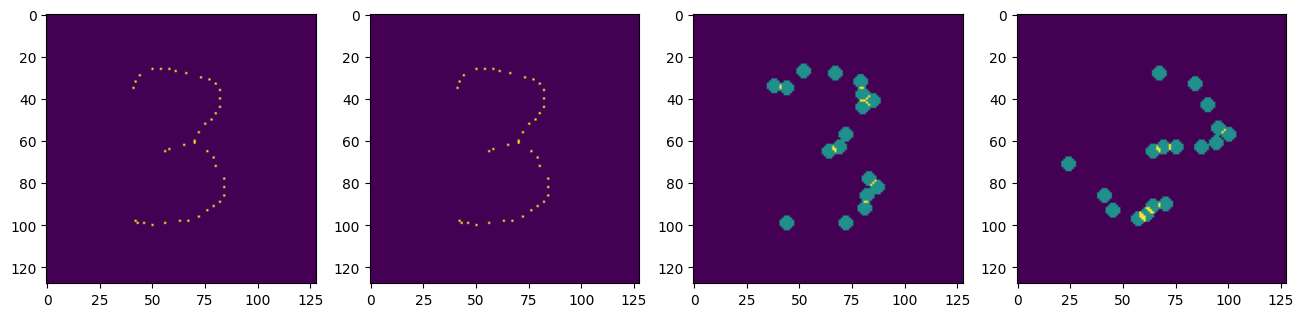

In [62]:
signal_ind = RNG.choice(signals_input.shape[0])
# signal_ind = 0
signal_input = xp_array_from_gpu(signals_input[signal_ind])
signal_output = signals_output[signal_ind]

# xy_list_input = PIXEL_FEATURE_XY_ARRAY[debundle_sbv(signal_input, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)]
# xy_list_output = PIXEL_FEATURE_XY_ARRAY[debundle_sbv(signal_output, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)]
# ohe_input = xy_list_to_ohe_vec(xy_list_input)
# ohe_output = xy_list_to_ohe_vec(xy_list_output)

pixel_feature_inds = debundle_sbv(signal_input, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_input = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
pixel_feature_inds = debundle_sbv(signal_output, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(raw_signals_input[signal_ind])))
# ax2.imshow(vec_to_square_matrix(ohe_input))
# ax3.imshow(vec_to_square_matrix(ohe_output));
ax2.imshow(vec_to_square_matrix(bm_input))
ax3.imshow(vec_to_square_matrix(bm_output));

# Test

In [128]:
df_clusters = pd.read_sql('SELECT output_bit, metas, nzb_list FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code', 
                          params={
                              'encoding': HP_SIGNAL_ENCODING, 
                              'transf_code': TRANSF_CODE},
                          con=transfs_db_con)
clusters = []
cluster_metas = []

for cluster_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
    cluster_nzb_list_for_output_bit = pickle.loads(cluster_row.nzb_list)
    cluster_metas_for_output_bit = pickle.loads(cluster_row.metas)
    assert len(cluster_nzb_list_for_output_bit) == len(cluster_metas_for_output_bit)

    for nzb, meta in zip(cluster_nzb_list_for_output_bit, cluster_metas_for_output_bit):
        assert len(nzb) > 0
        
        if meta.state in [ClusterState.PROD_WORK, ClusterState.PROD_ETERNAL]:
            cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
            cluster[nzb] = 1
            clusters.append(cluster)
        
            cluster_ind = len(clusters)
            meta.cluster_ind = cluster_ind
            cluster_metas.append(meta)

clusters = np.vstack(clusters)
assert clusters.shape[0] == len(cluster_metas)
    
cluster_ones_counts = np.array(list(map(lambda m: m.ones_count, cluster_metas)), dtype='f')
cluster_output_bits = np.array(list(map(lambda m: m.output_bit, cluster_metas)), dtype='i')
cluster_input_bits_list = list(map(lambda m: m.input_bits, cluster_metas))
clusters.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

(460258, 1000)

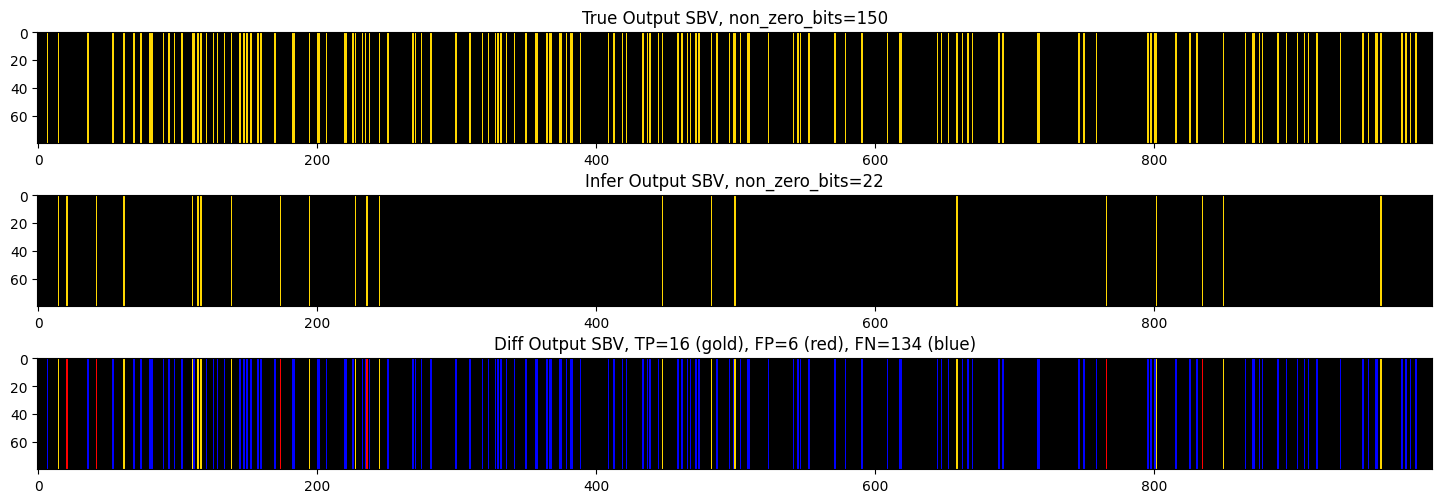

In [221]:
signals_generator = RealImageSignalsGenerator(TRANSF, 1, 1)
# signals_generator = PooledPixelFeatureSignalsGenerator(TRANSF, 1, 100)
sgr = signals_generator()

input_sbv = sgr.signals_input[0]
true_output_sbv = sgr.signals_output[0]
infer_output_sbv = np.zeros_like(input_sbv)

activated_clusters_boolmap = (clusters @ input_sbv) >= cluster_ones_counts
output_bit_to_activated_clusters_count = Counter(cluster_output_bits[activated_clusters_boolmap])
infer_output_sbv[list(output_bit_to_activated_clusters_count.keys())] = list(output_bit_to_activated_clusters_count.values())
infer_output_sbv = np.where(infer_output_sbv > 0, 1, 0)
condition_00 = (true_output_sbv == 0) & (infer_output_sbv == 0)
condition_01 = (true_output_sbv == 0) & (infer_output_sbv == 1)
condition_11 = (true_output_sbv == 1) & (infer_output_sbv == 1)
diff_output_sbv = np.where(condition_00, 0, np.where(condition_11, 1, np.where(condition_01, 2, 3)))

colors = ['black', 'gold', 'red', 'blue']
bounds = [0, 1, 2, 3, 4]
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figwidth(18)
fig.set_figheight(6)
ax1.set_title(f'True Output SBV, non_zero_bits={np.count_nonzero(true_output_sbv)}')
ax1.imshow(np.ones((80, 1)) * true_output_sbv, interpolation='none', cmap=cmap, norm=norm);
ax2.set_title(f'Infer Output SBV, non_zero_bits={np.count_nonzero(infer_output_sbv)}')
ax2.imshow(np.ones((80, 1)) * infer_output_sbv, interpolation='none', cmap=cmap, norm=norm);
ax3.set_title(f'Diff Output SBV, TP={(diff_output_sbv == 1).sum()} (gold), FP={(diff_output_sbv == 2).sum()} (red), FN={(diff_output_sbv == 3).sum()} (blue)')
ax3.imshow(np.ones((80, 1)) * diff_output_sbv, interpolation='none', cmap=cmap, norm=norm);

  0%|          | 0/100 [00:00<?, ?it/s]

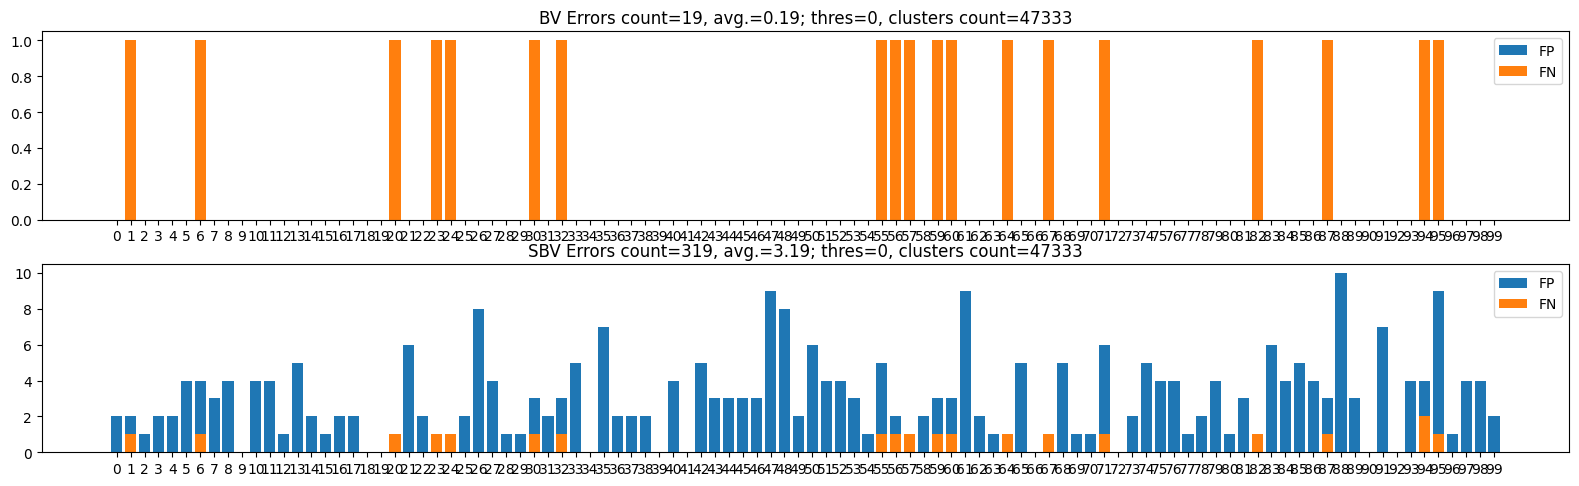

In [107]:
thres = 0
toy_image_ids = get_random_toy_image_ids(100)
bv_errors_count_list = defaultdict(list)
sbv_errors_count_list = defaultdict(list)

for toy_image_id in tqdm(toy_image_ids):
    toy_image_origin = get_toy_image(toy_image_id)
    toy_image_transf = transform_toy_image(toy_image_origin, TRANSF)

    toy_image_origin_sbv = calc_toy_image_sbv(toy_image_origin)
    toy_image_transf_sbv = calc_toy_image_sbv(toy_image_transf)
    
    activated_clusters_mask = (clusters @ toy_image_origin_sbv) >= cluster_ones_counts
    
    toy_image_infer_sbv = np.zeros_like(toy_image_origin_sbv)

    # Approach 1: judge if output_bit is ON/OFF based on number of activated clusters
    output_bit_to_activated_clusters_count = Counter(cluster_output_bits[activated_clusters_mask])
    toy_image_infer_sbv[list(output_bit_to_activated_clusters_count.keys())] = list(output_bit_to_activated_clusters_count.values())
    toy_image_infer_sbv = np.where(toy_image_infer_sbv > thres, 1, 0)

    # Approach 2: judge if output_bit is ON/OFF based on number of unique bits touched by clusters within input signal
    # output_bit_to_unique_input_bits = defaultdict(set)

    # for mask_value, output_bit, input_bits in zip(activated_clusters_mask, cluster_output_bits, cluster_input_bits_list):
    #     if not mask_value:
    #         continue

    #     output_bit_to_unique_input_bits[output_bit].update(input_bits)
    # toy_image_infer_sbv[list(output_bit_to_unique_input_bits.keys())] = list(map(len, output_bit_to_unique_input_bits.values()))
    # toy_image_infer_sbv = np.where(toy_image_infer_sbv > thres, 1, 0)
    
    sbv_false_positives_count = (toy_image_transf_sbv[toy_image_infer_sbv == 1] == 0).sum()
    sbv_false_negatives_count = (toy_image_transf_sbv[toy_image_infer_sbv == 0] == 1).sum()
    assert np.count_nonzero(toy_image_transf_sbv != toy_image_infer_sbv) == (sbv_false_positives_count + sbv_false_negatives_count)
    sbv_errors_count_list['FP'].append(sbv_false_positives_count)
    sbv_errors_count_list['FN'].append(sbv_false_negatives_count)
    
    toy_image_infer_bv = toy_image_sbv_to_bv(toy_image_infer_sbv)
    toy_image_transf_bv = toy_image_sbv_to_bv(toy_image_transf_sbv)
    bv_false_positives_count = (toy_image_transf_bv[toy_image_infer_bv == 1] == 0).sum()
    bv_false_negatives_count = (toy_image_transf_bv[toy_image_infer_bv == 0] == 1).sum()
    assert np.count_nonzero(toy_image_transf_bv != toy_image_infer_bv) == (bv_false_positives_count + bv_false_negatives_count)
    bv_errors_count_list['FP'].append(bv_false_positives_count)
    bv_errors_count_list['FN'].append(bv_false_negatives_count)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)
fig.tight_layout() 
errors_count = sum(itertools.chain.from_iterable(bv_errors_count_list.values()))
ax1.set_title(f'BV Errors count={errors_count}, avg.={errors_count / len(toy_image_ids):.2f}; thres={thres}, clusters count={clusters.shape[0]}')

for error_kind, errors_count in bv_errors_count_list.items():
    ax1.bar(list(map(str, range(len(toy_image_ids)))), errors_count, label=error_kind)

ax1.legend()

errors_count = sum(itertools.chain.from_iterable(sbv_errors_count_list.values()))
ax2.set_title(f'SBV Errors count={errors_count}, avg.={errors_count / len(toy_image_ids):.2f}; thres={thres}, clusters count={clusters.shape[0]}')

for error_kind, errors_count in sbv_errors_count_list.items():
    ax2.bar(list(map(str, range(len(toy_image_ids)))), errors_count, label=error_kind)

ax2.legend();

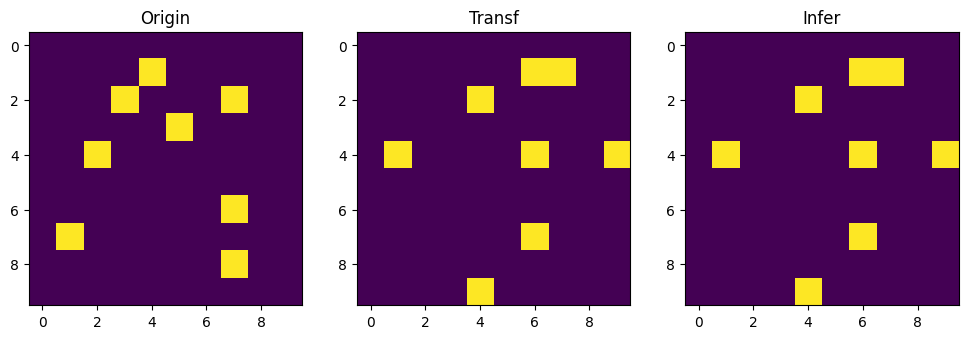

In [116]:
toy_image_id = get_random_toy_image_ids(1)[0]
toy_image = get_toy_image(toy_image_id)
toy_image_sbv = calc_toy_image_sbv(toy_image)

toy_image_transf = transform_toy_image(toy_image, TRANSF)
toy_image_transf_sbv = encode_toy_image_sbv(toy_image_transf)

activated_clusters_mask = (clusters @ toy_image_sbv) >= cluster_ones_counts
values = Counter(cluster_output_bits[activated_clusters_mask])
toy_image_sbv_out = np.zeros_like(toy_image_sbv)
# toy_image_sbv_out[list(values.keys())] = list(values.values())
# toy_image_sbv_out = np.where(toy_image_sbv_out > 1, 1, 0)
toy_image_sbv_out[list(values.keys())] = 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(12)
ax1.set_title('Origin')
ax1.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_sbv)))
ax2.set_title('Transf')
ax2.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_transf_sbv)))
ax3.set_title('Infer')
ax3.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_sbv_out)));

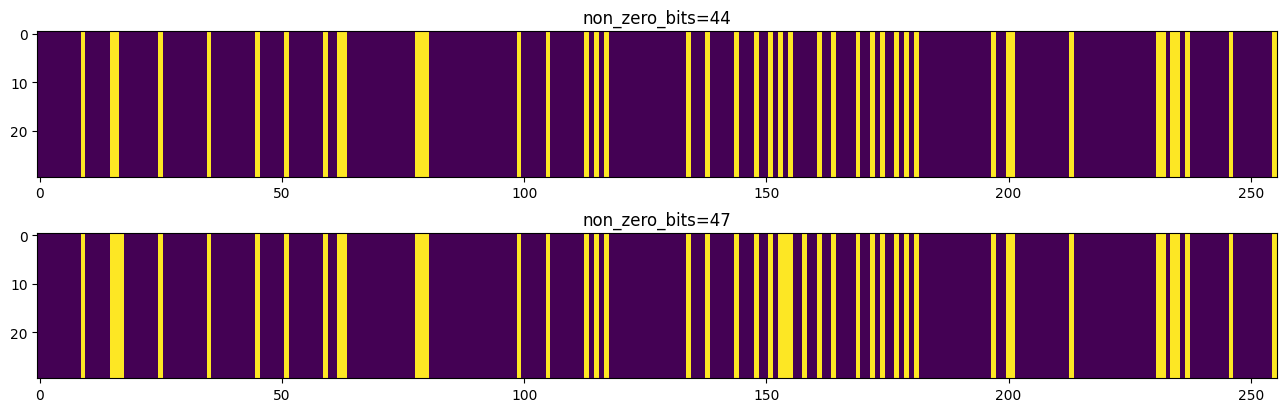

In [110]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)

toy_image_transf = transform_toy_image(toy_image, TRANSF)
toy_image_transf_sbv = encode_toy_image_sbv(toy_image_transf)

ax1.set_title(f'non_zero_bits={toy_image_transf_sbv.sum()}')
ax1.imshow(np.ones((30, 1)) * toy_image_transf_sbv);
ax2.set_title(f'non_zero_bits={toy_image_sbv_out.sum()}')
ax2.imshow(np.ones((30, 1)) * toy_image_sbv_out);